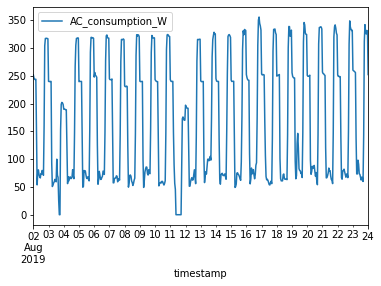

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv("../data/microgrid_processed_august.csv")
df.index = pd.to_datetime(df['timestamp'])
#Set
start_date =  "8/2/2019 0:00"
end_date = "8/24/2019 0:00"

#Parameter
dev = "AC_consumption_W"
                 
df_hist = df[start_date:end_date][dev].to_frame()
    
df_hist.plot()
plt.show()

In [7]:
# Get forecast 500 steps ahead in future
import statsmodels.api as sm

#Best SARIMA(0, 0, 0)x(0, 2, 2, 24)24 - AIC:6.0, Score:13.667989730834961, Time:0.7667989730834961
mod = sm.tsa.statespace.SARIMAX(df_hist[dev],
                                order=(0,0,0),
                                seasonal_order=(0,2,2, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.mle_retvals)
pred_uc = results.get_forecast(steps=48)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


{'fopt': -0.0, 'gopt': array([0., 0., 0.]), 'fcalls': 4, 'warnflag': 0, 'converged': True, 'iterations': 0}


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1184: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /


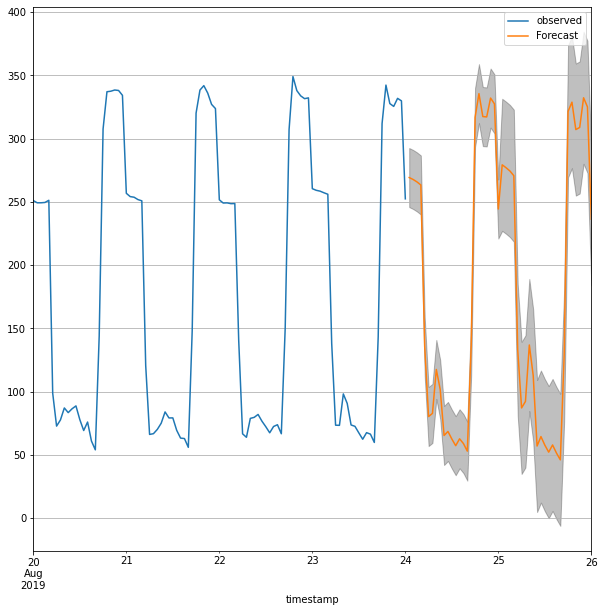

In [8]:

fix,ax = plt.subplots()

start_date =  "8/20/2019 0:00"
end_date = "8/24/2019 0:00"
df_hist = df[start_date:end_date][dev].to_frame()

ax = df_hist[dev].plot(label='observed', figsize=(10, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.legend()
plt.grid()
plt.show()

In [4]:
import itertools
import statsmodels.api as sm
import math 
import datetime
import time
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

##Best SARIMA(1, 1, 2)x(0, 2, 2, 24)24 - AIC:5806.556061333564 - range(0, 3)
##Best SARIMA(1, 1, 1)x(1, 1, 1, 24)24 - AIC:6161.695793029599 - range(0.2)
print('Examples of parameter combinations for Seasonal ARIMA...',datetime.datetime.now())
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

best_mod = None
best_aic = None
best_param = None
best_seasonal = None
best_time = None
best_score = 999000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            start = time.time()
            mod = sm.tsa.statespace.SARIMAX(df_hist[dev],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            end = time.time()-start
            score = results.aic+end*10
            print('SARIMA{}x{}24 - AIC:{},Score:{},ProcTime:{}'.format(param, param_seasonal, results.aic,score,end))
            if best_score > score:
                best_mod = results
                best_aic = results.aic
                best_param = param
                best_seasonal = param_seasonal
                best_score = score
                best_time = end
        except Exception as ex:
            print(ex)
            continue
print('Best SARIMA{}x{}24 - AIC:{}, Score:{}, Time:{}'.format(best_param, best_seasonal, best_aic,best_score,best_time))
print('Finished:',datetime.datetime.now())

Examples of parameter combinations for Seasonal ARIMA... 2020-09-08 08:21:43.170567
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 0, 2, 24)
SARIMAX: (0, 0, 2) x (0, 1, 0, 24)
SARIMAX: (0, 0, 2) x (0, 1, 1, 24)
SARIMA(0, 0, 0)x(0, 0, 0, 24)24 - AIC:1302.4816580864228,Score:1302.7001186462678,ProcTime:0.02184605598449707


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(0, 0, 1, 24)24 - AIC:932.4176179402571,Score:934.4784199231367,ProcTime:0.20608019828796387


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(0, 0, 2, 24)24 - AIC:612.5787103214709,Score:620.118662122771,ProcTime:0.7539951801300049
SARIMA(0, 0, 0)x(0, 1, 0, 24)24 - AIC:508.36885291573253,Score:508.64289838310924,ProcTime:0.0274045467376709


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:901: RuntimeWarning: Mean of empty slice.
  params_variance

SARIMA(0, 0, 0)x(0, 1, 1, 24)24 - AIC:nan,Score:nan,ProcTime:0.5285470485687256
SARIMA(0, 0, 0)x(0, 1, 2, 24)24 - AIC:173.54838481169287,Score:184.67774977903906,ProcTime:1.1129364967346191
SARIMA(0, 0, 0)x(0, 2, 0, 24)24 - AIC:378.26024817346195,Score:379.43260001062015,ProcTime:0.11723518371582031


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(0, 2, 1, 24)24 - AIC:187.78970926838107,Score:196.3610813005466,ProcTime:0.8571372032165527


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1184: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warni

SARIMA(0, 0, 0)x(0, 2, 2, 24)24 - AIC:6.0,Score:13.667989730834961,ProcTime:0.7667989730834961
SARIMA(0, 0, 0)x(1, 0, 0, 24)24 - AIC:516.8973417712426,Score:517.52399162781,ProcTime:0.06266498565673828
SARIMA(0, 0, 0)x(1, 0, 1, 24)24 - AIC:510.90935931311793,Score:513.4899662505263,ProcTime:0.2580606937408447


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(1, 0, 2, 24)24 - AIC:341.6919963052981,Score:365.73689624578884,ProcTime:2.4044899940490723
SARIMA(0, 0, 0)x(1, 1, 0, 24)24 - AIC:343.8997936583511,Score:344.65093854436793,ProcTime:0.07511448860168457


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 0, 0)x(1, 1, 1, 24)24 - AIC:nan,Score:nan,ProcTime:0.7256295680999756
SARIMA(0, 0, 0)x(1, 1, 2, 24)24 - AIC:175.3852725773168,Score:189.90305431178336,ProcTime:1.4517781734466553


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(1, 2, 0, 24)24 - AIC:194.89957738586892,Score:197.5269382066392,ProcTime:0.26273608207702637


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(1, 2, 1, 24)24 - AIC:188.7376789265474,Score:204.78126804169023,ProcTime:1.6043589115142822


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(1, 2, 2, 24)24 - AIC:8.0,Score:17.523940086364746,ProcTime:0.9523940086364746


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(2, 0, 0, 24)24 - AIC:345.87623010996305,Score:349.148365367684,ProcTime:0.3272135257720947


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(0, 0, 0)x(2, 0, 1, 24)24 - AIC:347.42033993472467,Score:372.8089336084307,ProcTime:2.5388593673706055


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(2, 0, 2, 24)24 - AIC:343.2511708183793,Score:374.30826396184244,ProcTime:3.1057093143463135
SARIMA(0, 0, 0)x(2, 1, 0, 24)24 - AIC:179.24574338215064,Score:182.49570571201514,ProcTime:0.3249962329864502


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 0)x(2, 1, 1, 24)24 - AIC:nan,Score:nan,ProcTime:2.170780658721924


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(2, 1, 2, 24)24 - AIC:174.44532108390015,Score:205.0097246178357,ProcTime:3.0564403533935547


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 0)x(2, 2, 0, 24)24 - AIC:nan,Score:nan,ProcTime:3.773314952850342


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 0)x(2, 2, 1, 24)24 - AIC:nan,Score:nan,ProcTime:55.675922870635986


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 0)x(2, 2, 2, 24)24 - AIC:10.0,Score:21.30873203277588,ProcTime:1.130873203277588
SARIMA(0, 0, 1)x(0, 0, 0, 24)24 - AIC:1174.2833768789978,Score:1174.9447190230103,ProcTime:0.06613421440124512


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(0, 0, 1, 24)24 - AIC:834.3293263395079,Score:837.9363848645934,ProcTime:0.3607058525085449


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(0, 0, 2, 24)24 - AIC:544.0057928635093,Score:560.359123475692,ProcTime:1.6353330612182617
SARIMA(0, 0, 1)x(0, 1, 0, 24)24 - AIC:494.6449122940143,Score:495.1624427352985,ProcTime:0.05175304412841797


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 0, 1)x(0, 1, 1, 24)24 - AIC:2126.066619158698,Score:2146.3001906880863,ProcTime:2.0233571529388428
SARIMA(0, 0, 1)x(0, 1, 2, 24)24 - AIC:153.24731792059836,Score:174.400236259374,ProcTime:2.1152918338775635


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(0, 2, 0, 24)24 - AIC:367.44199189203556,Score:369.59433707254703,ProcTime:0.21523451805114746


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(0, 2, 1, 24)24 - AIC:179.47436957215493,Score:194.83123450135415,ProcTime:1.5356864929199219


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(0, 2, 2, 24)24 - AIC:8.0,Score:18.273499488830566,ProcTime:1.0273499488830566


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(1, 0, 0, 24)24 - AIC:509.2257664472921,Score:511.74575784514974,ProcTime:0.2519991397857666


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(1, 0, 1, 24)24 - AIC:497.66747231321125,Score:505.3677319987276,ProcTime:0.7700259685516357


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(1, 0, 2, 24)24 - AIC:329.0794158776122,Score:364.17423494652087,ProcTime:3.509481906890869


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(1, 1, 0, 24)24 - AIC:338.1694622892554,Score:341.3719221014197,ProcTime:0.32024598121643066


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(1, 1, 1, 24)24 - AIC:325.7559201644338,Score:338.2758042739309,ProcTime:1.251988410949707


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(1, 1, 2, 24)24 - AIC:154.79447962741637,Score:182.0381987283685,ProcTime:2.724371910095215


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(1, 2, 0, 24)24 - AIC:193.70875084349723,Score:203.942284225913,ProcTime:1.0233533382415771


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(1, 2, 1, 24)24 - AIC:180.45841048161247,Score:204.64076350132683,ProcTime:2.4182353019714355


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(1, 2, 2, 24)24 - AIC:10.0,Score:22.313790321350098,ProcTime:1.2313790321350098


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(0, 0, 1)x(2, 0, 0, 24)24 - AIC:349.2615610869592,Score:370.89527194816526,ProcTime:2.1633710861206055


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 1)x(2, 0, 1, 24)24 - AIC:343.79242091727,Score:380.76167254996045,ProcTime:3.696925163269043


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 1)x(2, 0, 2, 24)24 - AIC:331.4234931392837,Score:400.854836217897,ProcTime:6.943134307861328


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(2, 1, 0, 24)24 - AIC:162.9991213478197,Score:182.78986851349964,ProcTime:1.9790747165679932


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(2, 1, 1, 24)24 - AIC:164.4964046007246,Score:226.8847078806013,ProcTime:6.238830327987671


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 1)x(2, 1, 2, 24)24 - AIC:153.171501368727,Score:241.2924983207839,ProcTime:8.812099695205688


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 1)x(2, 2, 0, 24)24 - AIC:nan,Score:nan,ProcTime:19.971270322799683


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 1)x(2, 2, 1, 24)24 - AIC:12.87949353310717,Score:218.7397101506914,ProcTime:20.586021661758423


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 1)x(2, 2, 2, 24)24 - AIC:12.0,Score:26.199366569519043,ProcTime:1.4199366569519043
SARIMA(0, 0, 2)x(0, 0, 0, 24)24 - AIC:1093.5439331397674,Score:1094.7843129501007,ProcTime:0.1240379810333252


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(0, 0, 1, 24)24 - AIC:778.7642593089575,Score:785.5887980166907,ProcTime:0.6824538707733154


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(0, 0, 2, 24)24 - AIC:501.635348076507,Score:525.1818411299432,ProcTime:2.354649305343628
SARIMA(0, 0, 2)x(0, 1, 0, 24)24 - AIC:490.06031503586496,Score:490.83350410370554,ProcTime:0.07731890678405762


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 0, 2)x(0, 1, 1, 24)24 - AIC:2190.7709451875976,Score:2215.082075234442,ProcTime:2.4311130046844482


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(0, 1, 2, 24)24 - AIC:149.0547695181905,Score:196.88355350714315,ProcTime:4.782878398895264


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(0, 2, 0, 24)24 - AIC:361.5407071652178,Score:365.25709252975025,ProcTime:0.37163853645324707


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(0, 2, 1, 24)24 - AIC:174.01959449274437,Score:193.57492476923363,ProcTime:1.9555330276489258


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(0, 2, 2, 24)24 - AIC:10.0,Score:24.70022678375244,ProcTime:1.4700226783752441


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(0, 0, 2)x(1, 0, 0, 24)24 - AIC:510.9522218459074,Score:516.8879384749357,ProcTime:0.593571662902832


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(1, 0, 1, 24)24 - AIC:493.41150820957847,Score:503.23202193485923,ProcTime:0.9820513725280762


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 2)x(1, 0, 2, 24)24 - AIC:326.83069260130634,Score:376.2014606715273,ProcTime:4.937076807022095


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(1, 1, 0, 24)24 - AIC:340.0481539544311,Score:343.88963754741815,ProcTime:0.38414835929870605


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(1, 1, 1, 24)24 - AIC:322.14768650141644,Score:360.67793132868695,ProcTime:3.853024482727051


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(1, 1, 2, 24)24 - AIC:150.32684928158753,Score:214.5944893954181,ProcTime:6.426764011383057


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(1, 2, 0, 24)24 - AIC:194.99186592731684,Score:224.87265902195185,ProcTime:2.988079309463501


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(1, 2, 1, 24)24 - AIC:175.06186633247296,Score:222.12682633537213,ProcTime:4.706496000289917


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(1, 2, 2, 24)24 - AIC:12.0,Score:29.572808265686035,ProcTime:1.7572808265686035


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(0, 0, 2)x(2, 0, 0, 24)24 - AIC:342.03263828800834,Score:377.56202290104545,ProcTime:3.552938461303711


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 2)x(2, 0, 1, 24)24 - AIC:345.77497125342353,Score:384.3394291467951,ProcTime:3.856445789337158


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 2)x(2, 0, 2, 24)24 - AIC:332.58654602580543,Score:399.60918911509987,ProcTime:6.702264308929443


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(2, 1, 0, 24)24 - AIC:164.26525982780993,Score:195.5678096668297,ProcTime:3.1302549839019775


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(2, 1, 1, 24)24 - AIC:165.82839439332272,Score:222.32057044923093,ProcTime:5.64921760559082


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 2)x(2, 1, 2, 24)24 - AIC:148.78789258990804,Score:256.73896862063924,ProcTime:10.79510760307312


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 2)x(2, 2, 0, 24)24 - AIC:-2.801777952466388,Score:318.77064264461,ProcTime:32.15724205970764


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 0, 2)x(2, 2, 1, 24)24 - AIC:12.233931075808641,Score:269.39305688070976,ProcTime:25.715912580490112


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 0, 2)x(2, 2, 2, 24)24 - AIC:14.0,Score:34.037195682525635,ProcTime:2.0037195682525635
SARIMA(0, 1, 0)x(0, 0, 0, 24)24 - AIC:1019.0564406807898,Score:1019.2364896233557,ProcTime:0.018004894256591797


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(0, 0, 1, 24)24 - AIC:2792.8245546146027,Score:2795.5147935672394,ProcTime:0.2690238952636719


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(0, 0, 2, 24)24 - AIC:466.5055755237788,Score:476.71093498270216,ProcTime:1.020535945892334
SARIMA(0, 1, 0)x(0, 1, 0, 24)24 - AIC:518.0446859692256,Score:518.3821126316707,ProcTime:0.033742666244506836


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(0, 1, 1, 24)24 - AIC:340.4525658847798,Score:343.38285181541335,ProcTime:0.2930285930633545


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(0, 1, 2, 24)24 - AIC:159.40162972467385,Score:173.71262387292825,ProcTime:1.4310994148254395
SARIMA(0, 1, 0)x(0, 2, 0, 24)24 - AIC:381.7998514445347,Score:383.4057030947727,ProcTime:0.1605851650238037


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(0, 2, 1, 24)24 - AIC:185.919706625782,Score:195.95652799113844,ProcTime:1.0036821365356445


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(0, 2, 2, 24)24 - AIC:6.0,Score:14.989419937133789,ProcTime:0.8989419937133789
SARIMA(0, 1, 0)x(1, 0, 0, 24)24 - AIC:524.4892946817376,Score:525.1060668565729,ProcTime:0.06167721748352051


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 1, 0)x(1, 0, 1, 24)24 - AIC:2382.01460208418,Score:2388.602302927991,ProcTime:0.6587700843811035
SARIMA(0, 1, 0)x(1, 0, 2, 24)24 - AIC:342.0372628551033,Score:358.3617805820015,ProcTime:1.6324517726898193
SARIMA(0, 1, 0)x(1, 1, 0, 24)24 - AIC:346.68899304451605,Score:347.76474721016547,ProcTime:0.1075754165649414


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(1, 1, 1, 24)24 - AIC:341.2226051093843,Score:348.8349074126985,ProcTime:0.7612302303314209


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(1, 1, 2, 24)24 - AIC:161.05747347127317,Score:180.7909548784387,ProcTime:1.9733481407165527


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(1, 2, 0, 24)24 - AIC:192.83124192665403,Score:196.75617440651243,ProcTime:0.39249324798583984


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(1, 2, 1, 24)24 - AIC:187.90615343798436,Score:223.53070521105565,ProcTime:3.562455177307129


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(1, 2, 2, 24)24 - AIC:8.0,Score:19.87650203704834,ProcTime:1.187650203704834


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(2, 0, 0, 24)24 - AIC:347.61019634982915,Score:350.9723250844178,ProcTime:0.3362128734588623


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(0, 1, 0)x(2, 0, 1, 24)24 - AIC:1497.6817731972974,Score:1524.1387133714002,ProcTime:2.6456940174102783


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 1, 0)x(2, 0, 2, 24)24 - AIC:343.9792275616462,Score:381.56068088501047,ProcTime:3.758145332336426


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(2, 1, 0, 24)24 - AIC:160.36304879456858,Score:164.6144073036323,ProcTime:0.42513585090637207


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(2, 1, 1, 24)24 - AIC:162.3526462068677,Score:198.60147080327272,ProcTime:3.624882459640503


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(2, 1, 2, 24)24 - AIC:158.8677899038419,Score:229.89317099209873,ProcTime:7.102538108825684


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(2, 2, 0, 24)24 - AIC:6.0,Score:15.669394493103027,ProcTime:0.9669394493103027


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(2, 2, 1, 24)24 - AIC:8.0,Score:21.485751152038574,ProcTime:1.3485751152038574


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0)x(2, 2, 2, 24)24 - AIC:10.0,Score:23.754143714904785,ProcTime:1.3754143714904785
SARIMA(0, 1, 1)x(0, 0, 0, 24)24 - AIC:987.0590815211021,Score:987.387953724929,ProcTime:0.03288722038269043


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 1, 1)x(0, 0, 1, 24)24 - AIC:nan,Score:nan,ProcTime:0.45516085624694824
SARIMA(0, 1, 1)x(0, 0, 2, 24)24 - AIC:444.3401756503971,Score:461.3824334361942,ProcTime:1.704225778579712


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(0, 1, 0, 24)24 - AIC:496.72182707533295,Score:499.30225758299287,ProcTime:0.2580430507659912


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(0, 1, 1, 24)24 - AIC:324.55955466541513,Score:335.6443639686988,ProcTime:1.1084809303283691


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(0, 1, 2, 24)24 - AIC:155.34152261924638,Score:187.7125190944661,ProcTime:3.2370996475219727


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(0, 2, 0, 24)24 - AIC:364.2940581754124,Score:367.5875152066624,ProcTime:0.329345703125


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(0, 2, 1, 24)24 - AIC:174.260414129934,Score:190.356765276632,ProcTime:1.6096351146697998


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(0, 2, 2, 24)24 - AIC:8.0,Score:21.00623655319214,ProcTime:1.3006236553192139


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(1, 0, 0, 24)24 - AIC:511.02447432555175,Score:513.3056942848108,ProcTime:0.22812199592590332


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(1, 0, 1, 24)24 - AIC:6406.803754103268,Score:6412.491195929135,ProcTime:0.5687441825866699


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(1, 0, 2, 24)24 - AIC:327.1396932944862,Score:358.3297024116127,ProcTime:3.1190009117126465


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(1, 1, 0, 24)24 - AIC:337.4066969248232,Score:342.1250172945437,ProcTime:0.4718320369720459


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(1, 1, 1, 24)24 - AIC:326.3908576417638,Score:334.4287752557469,ProcTime:0.8037917613983154


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(1, 1, 2, 24)24 - AIC:157.12923519023204,Score:190.34294597514415,ProcTime:3.321371078491211


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(1, 2, 0, 24)24 - AIC:188.54861764209852,Score:204.7981717993556,ProcTime:1.624955415725708


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(1, 2, 1, 24)24 - AIC:176.4375164484131,Score:220.51313423863527,ProcTime:4.407561779022217


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(1, 2, 2, 24)24 - AIC:10.0,Score:25.27423858642578,ProcTime:1.5274238586425781


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(2, 0, 0, 24)24 - AIC:337.9010765663222,Score:358.23769260559834,ProcTime:2.0336616039276123


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(2, 0, 1, 24)24 - AIC:1623.813958668153,Score:1650.9618311161205,ProcTime:2.714787244796753


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(2, 0, 2, 24)24 - AIC:329.1112170717377,Score:370.0566778680939,ProcTime:4.09454607963562


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(2, 1, 0, 24)24 - AIC:161.46643511837294,Score:181.98286645000746,ProcTime:2.051643133163452


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(2, 1, 1, 24)24 - AIC:163.42035819547166,Score:205.939372077155,ProcTime:4.251901388168335


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(2, 1, 2, 24)24 - AIC:154.30142199472735,Score:246.75642287210772,ProcTime:9.245500087738037


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(2, 2, 0, 24)24 - AIC:8.0,Score:20.20984935760498,ProcTime:1.220984935760498


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(2, 2, 1, 24)24 - AIC:10.0,Score:24.987311363220215,ProcTime:1.4987311363220215


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 1)x(2, 2, 2, 24)24 - AIC:12.0,Score:31.03404951095581,ProcTime:1.903404951095581
SARIMA(0, 1, 2)x(0, 0, 0, 24)24 - AIC:978.4330105588529,Score:978.8984703824613,ProcTime:0.046545982360839844


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 1, 2)x(0, 0, 1, 24)24 - AIC:2149.8777733416414,Score:2160.7911120028352,ProcTime:1.0913338661193848
SARIMA(0, 1, 2)x(0, 0, 2, 24)24 - AIC:437.5669921960625,Score:450.76751843355026,ProcTime:1.3200526237487793
SARIMA(0, 1, 2)x(0, 1, 0, 24)24 - AIC:488.01375265230143,Score:489.31071395982707,ProcTime:0.12969613075256348


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(0, 1, 1, 24)24 - AIC:317.30162379549245,Score:324.0204095582793,ProcTime:0.6718785762786865


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(0, 1, 2, 24)24 - AIC:143.8023187753386,Score:178.68296405045456,ProcTime:3.4880645275115967


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(0, 2, 0, 24)24 - AIC:357.5569368167899,Score:363.46932418785315,ProcTime:0.5912387371063232


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(0, 2, 1, 24)24 - AIC:168.7867363455585,Score:189.9562462332538,ProcTime:2.1169509887695312


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(0, 2, 2, 24)24 - AIC:10.0,Score:25.707168579101562,ProcTime:1.5707168579101562


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(1, 0, 0, 24)24 - AIC:508.4778523915972,Score:513.5456490987506,ProcTime:0.506779670715332


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(1, 0, 1, 24)24 - AIC:5843.227399331562,Score:5845.907691461079,ProcTime:0.26802921295166016


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(1, 0, 2, 24)24 - AIC:319.6652359329767,Score:361.7697328888483,ProcTime:4.210449695587158


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(1, 1, 0, 24)24 - AIC:336.1560332993098,Score:342.76352050100047,ProcTime:0.6607487201690674


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(1, 1, 1, 24)24 - AIC:318.5901434485609,Score:330.43042255088636,ProcTime:1.184027910232544


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(1, 1, 2, 24)24 - AIC:145.37095055792355,Score:190.26186213705563,ProcTime:4.489091157913208


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(1, 2, 0, 24)24 - AIC:189.67234859024666,Score:209.2558623269715,ProcTime:1.9583513736724854


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(1, 2, 1, 24)24 - AIC:170.96538647430197,Score:230.64604147689596,ProcTime:5.968065500259399


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(1, 2, 2, 24)24 - AIC:12.0,Score:30.619446754455566,ProcTime:1.8619446754455566


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(0, 1, 2)x(2, 0, 0, 24)24 - AIC:341.5115461393175,Score:371.179543499547,ProcTime:2.966799736022949


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 1, 2)x(2, 0, 1, 24)24 - AIC:1171.2731112656604,Score:1218.8092531380664,ProcTime:4.753614187240601


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(2, 0, 2, 24)24 - AIC:321.661614330203,Score:367.4050177649564,ProcTime:4.574340343475342


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(2, 1, 0, 24)24 - AIC:157.8715838208269,Score:186.12244260454884,ProcTime:2.8250858783721924


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(2, 1, 1, 24)24 - AIC:159.2659727537104,Score:208.84396233195747,ProcTime:4.957798957824707


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(2, 1, 2, 24)24 - AIC:144.12854554196207,Score:248.75541569729654,ProcTime:10.462687015533447


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(2, 2, 0, 24)24 - AIC:10.0,Score:25.22263765335083,ProcTime:1.522263765335083


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(2, 2, 1, 24)24 - AIC:12.0,Score:29.786414623260498,ProcTime:1.7786414623260498


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 2)x(2, 2, 2, 24)24 - AIC:14.0,Score:36.325284481048584,ProcTime:2.2325284481048584
SARIMA(0, 2, 0)x(0, 0, 0, 24)24 - AIC:1022.7089535946644,Score:1022.880483841399,ProcTime:0.017153024673461914


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 2, 0)x(0, 0, 1, 24)24 - AIC:2125.6332660278226,Score:2131.7043281158353,ProcTime:0.6071062088012695
SARIMA(0, 2, 0)x(0, 0, 2, 24)24 - AIC:459.53812742939226,Score:469.89996577015154,ProcTime:1.0361838340759277
SARIMA(0, 2, 0)x(0, 1, 0, 24)24 - AIC:580.040033499102,Score:580.4385525382561,ProcTime:0.03985190391540527


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(0, 1, 1, 24)24 - AIC:377.51013189309356,Score:381.44223361962554,ProcTime:0.39321017265319824


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(0, 1, 2, 24)24 - AIC:169.380904573288,Score:186.64108170875554,ProcTime:1.726017713546753
SARIMA(0, 2, 0)x(0, 2, 0, 24)24 - AIC:421.05062335585745,Score:422.99658626174124,ProcTime:0.1945962905883789


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(0, 2, 1, 24)24 - AIC:199.79377962852962,Score:214.6919057538653,ProcTime:1.4898126125335693


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(0, 2, 2, 24)24 - AIC:6.0,Score:16.055418014526367,ProcTime:1.0055418014526367
SARIMA(0, 2, 0)x(1, 0, 0, 24)24 - AIC:583.6932896959511,Score:584.3878530847755,ProcTime:0.06945633888244629


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 2, 0)x(1, 0, 1, 24)24 - AIC:2894.892927990437,Score:2899.5559519391063,ProcTime:0.46630239486694336
SARIMA(0, 2, 0)x(1, 0, 2, 24)24 - AIC:377.15432901508177,Score:392.9849054349121,ProcTime:1.5830576419830322
SARIMA(0, 2, 0)x(1, 1, 0, 24)24 - AIC:384.7503188597423,Score:385.5824140059215,ProcTime:0.08320951461791992


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(1, 1, 1, 24)24 - AIC:377.7315903536101,Score:384.56620939886767,ProcTime:0.6834619045257568


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(1, 1, 2, 24)24 - AIC:170.88891431620232,Score:194.0564553432714,ProcTime:2.316754102706909


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(1, 2, 0, 24)24 - AIC:207.70424268433106,Score:211.02317712494386,ProcTime:0.3318934440612793


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(1, 2, 1, 24)24 - AIC:201.77496385944707,Score:236.6659159697376,ProcTime:3.4890952110290527


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(1, 2, 2, 24)24 - AIC:8.0,Score:20.671005725860596,ProcTime:1.2671005725860596


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(2, 0, 0, 24)24 - AIC:384.14445996229017,Score:387.91559100095594,ProcTime:0.37711310386657715


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(0, 2, 0)x(2, 0, 1, 24)24 - AIC:1830.8020814665174,Score:1859.458809734187,ProcTime:2.8656728267669678
SARIMA(0, 2, 0)x(2, 0, 2, 24)24 - AIC:379.13348420496874,Score:413.5700319611638,ProcTime:3.443654775619507


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(2, 1, 0, 24)24 - AIC:171.77028087103628,Score:175.37450221503042,ProcTime:0.36042213439941406


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(2, 1, 1, 24)24 - AIC:173.75728834655652,Score:195.10471571472058,ProcTime:2.1347427368164062


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(2, 1, 2, 24)24 - AIC:169.4801190588288,Score:229.6786668989472,ProcTime:6.019854784011841


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(2, 2, 0, 24)24 - AIC:6.0,Score:15.685530662536621,ProcTime:0.9685530662536621


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(2, 2, 1, 24)24 - AIC:8.0,Score:31.712003231048584,ProcTime:2.3712003231048584


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 0)x(2, 2, 2, 24)24 - AIC:10.0,Score:36.933531761169434,ProcTime:2.6933531761169434
SARIMA(0, 2, 1)x(0, 0, 0, 24)24 - AIC:1006.7443122165809,Score:1007.0972813861976,ProcTime:0.03529691696166992


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 2, 1)x(0, 0, 1, 24)24 - AIC:2426.161304601208,Score:2432.1535574278987,ProcTime:0.5992252826690674
SARIMA(0, 2, 1)x(0, 0, 2, 24)24 - AIC:453.0186411420004,Score:464.52250686084193,ProcTime:1.1503865718841553
SARIMA(0, 2, 1)x(0, 1, 0, 24)24 - AIC:510.6195410702746,Score:511.82902660112785,ProcTime:0.12094855308532715


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(0, 1, 1, 24)24 - AIC:331.14679098370584,Score:338.26781749966653,ProcTime:0.7121026515960693


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(0, 1, 2, 24)24 - AIC:150.83490174042703,Score:173.91485493409158,ProcTime:2.307995319366455


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(0, 2, 0, 24)24 - AIC:372.3511927358845,Score:377.23073174879346,ProcTime:0.48795390129089355


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(0, 2, 1, 24)24 - AIC:175.07536086756443,Score:200.8415165873215,ProcTime:2.576615571975708


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(0, 2, 2, 24)24 - AIC:8.0,Score:20.971456050872803,ProcTime:1.2971456050872803


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(1, 0, 0, 24)24 - AIC:524.4993233721109,Score:528.0157256166788,ProcTime:0.3516402244567871


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(1, 0, 1, 24)24 - AIC:2443.6677545120615,Score:2452.1841329147715,ProcTime:0.8516378402709961


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 2, 1)x(1, 0, 2, 24)24 - AIC:334.78300684074236,Score:378.35309379676653,ProcTime:4.357008695602417


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(1, 1, 0, 24)24 - AIC:343.8240984890398,Score:359.94088687633837,ProcTime:1.6116788387298584


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(1, 1, 1, 24)24 - AIC:333.14680643329405,Score:350.6270176912286,ProcTime:1.748021125793457


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(1, 1, 2, 24)24 - AIC:152.42254985213026,Score:182.2439481103395,ProcTime:2.982139825820923


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(1, 2, 0, 24)24 - AIC:190.98331172744264,Score:206.8697114733838,ProcTime:1.5886399745941162


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(1, 2, 1, 24)24 - AIC:177.07534000219852,Score:220.9509937459424,ProcTime:4.38756537437439


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(1, 2, 2, 24)24 - AIC:10.0,Score:25.944945812225342,ProcTime:1.5944945812225342


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(2, 0, 0, 24)24 - AIC:346.6676140777281,Score:367.8280855170897,ProcTime:2.1160471439361572


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(0, 2, 1)x(2, 0, 1, 24)24 - AIC:1643.4320577759308,Score:1684.8571452278657,ProcTime:4.1425087451934814
SARIMA(0, 2, 1)x(2, 0, 2, 24)24 - AIC:336.74037078261426,Score:371.7128978097444,ProcTime:3.4972527027130127


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(2, 1, 0, 24)24 - AIC:159.7447249341266,Score:184.09587353947327,ProcTime:2.435114860534668


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(2, 1, 1, 24)24 - AIC:161.73569829167937,Score:189.02337224187468,ProcTime:2.7287673950195312


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(2, 1, 2, 24)24 - AIC:151.5660089901233,Score:232.84570640833618,ProcTime:8.127969741821289


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(2, 2, 0, 24)24 - AIC:8.0,Score:20.116875648498535,ProcTime:1.2116875648498535


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(2, 2, 1, 24)24 - AIC:10.0,Score:24.90898847579956,ProcTime:1.490898847579956


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 1)x(2, 2, 2, 24)24 - AIC:12.0,Score:30.69548797607422,ProcTime:1.8695487976074219
SARIMA(0, 2, 2)x(0, 0, 0, 24)24 - AIC:973.2427918698507,Score:973.8849174763876,ProcTime:0.06421256065368652


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(0, 2, 2)x(0, 0, 1, 24)24 - AIC:2123.1188521685694,Score:2134.319175273428,ProcTime:1.1200323104858398
SARIMA(0, 2, 2)x(0, 0, 2, 24)24 - AIC:430.35294271806424,Score:449.71730448106473,ProcTime:1.9364361763000488


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(0, 1, 0, 24)24 - AIC:490.5465649640396,Score:493.2754968678787,ProcTime:0.27289319038391113


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(0, 1, 1, 24)24 - AIC:316.0929659938678,Score:331.07763806341734,ProcTime:1.498467206954956


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(0, 1, 2, 24)24 - AIC:146.812013548595,Score:183.37205545304445,ProcTime:3.6560041904449463


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(0, 2, 0, 24)24 - AIC:356.16879560333507,Score:368.7278399644496,ProcTime:1.2559044361114502


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(0, 2, 1, 24)24 - AIC:164.3135681438231,Score:229.52906277654404,ProcTime:6.521549463272095


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(0, 2, 2, 24)24 - AIC:10.0,Score:36.29849910736084,ProcTime:2.629849910736084


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(1, 0, 0, 24)24 - AIC:513.2016318009979,Score:517.6608078645355,ProcTime:0.44591760635375977


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(1, 0, 1, 24)24 - AIC:2411.611542603262,Score:2422.2707270591336,ProcTime:1.0659184455871582


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(1, 0, 2, 24)24 - AIC:321.59004236808755,Score:368.84552981010415,ProcTime:4.72554874420166


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(1, 1, 0, 24)24 - AIC:334.66796712847497,Score:354.32662563296105,ProcTime:1.9658658504486084


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 2, 2)x(1, 1, 1, 24)24 - AIC:318.18125851959314,Score:357.1254218420419,ProcTime:3.894416332244873


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(1, 1, 2, 24)24 - AIC:148.4869012997808,Score:194.27966691715142,ProcTime:4.5792765617370605


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(1, 2, 0, 24)24 - AIC:186.08767806258243,Score:228.67829858031314,ProcTime:4.259062051773071


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(1, 2, 1, 24)24 - AIC:165.11015696735544,Score:240.20595355243844,ProcTime:7.509579658508301


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(1, 2, 2, 24)24 - AIC:12.0,Score:31.448227882385254,ProcTime:1.9448227882385254


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(2, 0, 0, 24)24 - AIC:338.8751927926227,Score:368.66366306087224,ProcTime:2.978847026824951


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 2, 2)x(2, 0, 1, 24)24 - AIC:1635.8953822248718,Score:1680.7974327200195,ProcTime:4.4902050495147705


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(2, 0, 2, 24)24 - AIC:323.58248707264033,Score:372.90480610340205,ProcTime:4.932231903076172


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(2, 1, 0, 24)24 - AIC:161.16624088765474,Score:195.68506927968355,ProcTime:3.451882839202881


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(2, 1, 1, 24)24 - AIC:163.09755305621758,Score:221.15455130908623,ProcTime:5.805699825286865


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(0, 2, 2)x(2, 1, 2, 24)24 - AIC:146.1471682569152,Score:259.67675028053577,ProcTime:11.35295820236206


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(2, 2, 0, 24)24 - AIC:10.0,Score:25.15805959701538,ProcTime:1.515805959701538


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(2, 2, 1, 24)24 - AIC:12.0,Score:29.735047340393066,ProcTime:1.7735047340393066


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 2, 2)x(2, 2, 2, 24)24 - AIC:14.0,Score:36.09526300430298,ProcTime:2.209526300430298
SARIMA(1, 0, 0)x(0, 0, 0, 24)24 - AIC:1029.3692940507274,Score:1029.6637862954478,ProcTime:0.0294492244720459


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(0, 0, 1, 24)24 - AIC:731.2030775782218,Score:734.01685311762,ProcTime:0.28137755393981934


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(0, 0, 2, 24)24 - AIC:476.9820551114698,Score:498.6533264356275,ProcTime:2.1671271324157715
SARIMA(1, 0, 0)x(0, 1, 0, 24)24 - AIC:499.5208807093354,Score:500.27950955455026,ProcTime:0.07586288452148438


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(1, 0, 0)x(0, 1, 1, 24)24 - AIC:1990.7277656372503,Score:2032.331659870954,ProcTime:4.160389423370361
SARIMA(1, 0, 0)x(0, 1, 2, 24)24 - AIC:162.3134480419497,Score:177.54760608104272,ProcTime:1.5234158039093018
SARIMA(1, 0, 0)x(0, 2, 0, 24)24 - AIC:373.2356296554684,Score:374.20844183121915,ProcTime:0.09728121757507324


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(0, 2, 1, 24)24 - AIC:186.17056525295737,Score:199.00212443417075,ProcTime:1.283155918121338


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(0, 2, 2, 24)24 - AIC:8.0,Score:21.21296215057373,ProcTime:1.321296215057373


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(1, 0, 0, 24)24 - AIC:501.38407551406823,Score:507.1744831716915,ProcTime:0.5790407657623291


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(1, 0, 0)x(1, 0, 1, 24)24 - AIC:502.65885078425373,Score:516.5669604491707,ProcTime:1.3908109664916992
SARIMA(1, 0, 0)x(1, 0, 2, 24)24 - AIC:334.66426691941956,Score:364.5515998356793,ProcTime:2.9887332916259766


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(1, 1, 0, 24)24 - AIC:331.6983775682986,Score:334.42209525781277,ProcTime:0.272371768951416


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(1, 1, 1, 24)24 - AIC:332.4276065854401,Score:340.4422140149445,ProcTime:0.8014607429504395


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(1, 1, 2, 24)24 - AIC:163.98715443029522,Score:186.11586517706036,ProcTime:2.2128710746765137


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(1, 2, 0, 24)24 - AIC:185.95343412716454,Score:197.05118240673607,ProcTime:1.1097748279571533


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(1, 2, 1, 24)24 - AIC:187.13275227436438,Score:208.19757733234778,ProcTime:2.10648250579834


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(1, 2, 2, 24)24 - AIC:10.0,Score:24.403035640716553,ProcTime:1.4403035640716553


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(2, 0, 0, 24)24 - AIC:333.69325927595344,Score:350.86045316557136,ProcTime:1.716719388961792


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(2, 0, 1, 24)24 - AIC:334.6632805787409,Score:366.3584652863825,ProcTime:3.16951847076416


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(2, 0, 2, 24)24 - AIC:336.6627357690156,Score:378.64834053204663,ProcTime:4.198560476303101


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(2, 1, 0, 24)24 - AIC:158.19053544781846,Score:171.56562223218125,ProcTime:1.3375086784362793


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(2, 1, 1, 24)24 - AIC:159.01789529824438,Score:185.60776813531103,ProcTime:2.658987283706665


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(2, 1, 2, 24)24 - AIC:160.40743566207868,Score:215.75508094482404,ProcTime:5.534764528274536


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(2, 2, 0, 24)24 - AIC:8.0,Score:20.06312894821167,ProcTime:1.206312894821167


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(2, 2, 1, 24)24 - AIC:10.0,Score:24.452290534973145,ProcTime:1.4452290534973145


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 0)x(2, 2, 2, 24)24 - AIC:12.0,Score:29.04101800918579,ProcTime:1.704101800918579
SARIMA(1, 0, 1)x(0, 0, 0, 24)24 - AIC:996.0511658951068,Score:996.5440247818256,ProcTime:0.049285888671875


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(0, 0, 1, 24)24 - AIC:705.7193145876794,Score:709.5459590083032,ProcTime:0.38266444206237793


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(0, 0, 2, 24)24 - AIC:454.17911770063864,Score:470.751128217759,ProcTime:1.6572010517120361
SARIMA(1, 0, 1)x(0, 1, 0, 24)24 - AIC:495.4357830065466,Score:496.1368456858374,ProcTime:0.07010626792907715


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(1, 0, 1)x(0, 1, 1, 24)24 - AIC:2139.2111098074024,Score:2182.303076913268,ProcTime:4.309196710586548
SARIMA(1, 0, 1)x(0, 1, 2, 24)24 - AIC:154.79378658585662,Score:186.07904392533416,ProcTime:3.128525733947754


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(0, 2, 0, 24)24 - AIC:367.94620168777914,Score:372.5180877504012,ProcTime:0.45718860626220703


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(0, 2, 1, 24)24 - AIC:181.13602765769429,Score:199.7430981037087,ProcTime:1.8607070446014404


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(0, 2, 2, 24)24 - AIC:10.0,Score:24.584057331085205,ProcTime:1.4584057331085205


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(1, 0, 0, 24)24 - AIC:503.2415735567853,Score:507.43374226940125,ProcTime:0.4192168712615967


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(1, 0, 1, 24)24 - AIC:498.60756998657246,Score:506.42150288223286,ProcTime:0.78139328956604


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 0, 1)x(1, 0, 2, 24)24 - AIC:332.12378997788085,Score:377.197623443457,ProcTime:4.507383346557617


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(1, 1, 0, 24)24 - AIC:333.63105474774886,Score:338.2878368980174,ProcTime:0.46567821502685547


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(1, 1, 1, 24)24 - AIC:327.7552220123307,Score:344.4532224433915,ProcTime:1.669800043106079


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(1, 1, 2, 24)24 - AIC:156.07885492918948,Score:193.5096420156763,ProcTime:3.7430787086486816


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(1, 2, 0, 24)24 - AIC:187.94953639196504,Score:204.8738294331943,ProcTime:1.6924293041229248


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(1, 2, 1, 24)24 - AIC:182.09078876803554,Score:212.85276977847255,ProcTime:3.076198101043701


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(1, 2, 2, 24)24 - AIC:12.0,Score:47.295820236206055,ProcTime:3.5295820236206055


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(1, 0, 1)x(2, 0, 0, 24)24 - AIC:335.8364893083236,Score:370.4868627671859,ProcTime:3.4650373458862305


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 0, 1)x(2, 0, 1, 24)24 - AIC:337.5466263931149,Score:378.14705974272425,ProcTime:4.0600433349609375


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 0, 1)x(2, 0, 2, 24)24 - AIC:332.85871259562833,Score:376.89342252604825,ProcTime:4.403470993041992


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(2, 1, 0, 24)24 - AIC:157.29901837358028,Score:188.8669018650964,ProcTime:3.1567883491516113


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(2, 1, 1, 24)24 - AIC:158.87918949616324,Score:206.54673100006949,ProcTime:4.766754150390625


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(2, 1, 2, 24)24 - AIC:154.55776544459886,Score:255.96730562099046,ProcTime:10.14095401763916


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(2, 2, 0, 24)24 - AIC:10.0,Score:24.65965509414673,ProcTime:1.4659655094146729


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(2, 2, 1, 24)24 - AIC:12.0,Score:28.94254159927368,ProcTime:1.6942541599273682


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 1)x(2, 2, 2, 24)24 - AIC:14.0,Score:33.81355428695679,ProcTime:1.9813554286956787
SARIMA(1, 0, 2)x(0, 0, 0, 24)24 - AIC:987.3891496558106,Score:988.0317568678772,ProcTime:0.06426072120666504


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(0, 0, 1, 24)24 - AIC:698.1216772715368,Score:703.9395555178442,ProcTime:0.5817878246307373


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(0, 0, 2, 24)24 - AIC:447.6367653389442,Score:468.3542240639198,ProcTime:2.0717458724975586
SARIMA(1, 0, 2)x(0, 1, 0, 24)24 - AIC:491.3065195959649,Score:492.529742805346,ProcTime:0.12232232093811035


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(1, 0, 2)x(0, 1, 1, 24)24 - AIC:2197.360187645424,Score:2225.6951223568803,ProcTime:2.83349347114563


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(0, 1, 2, 24)24 - AIC:150.74436554942443,Score:195.3674973014386,ProcTime:4.462313175201416


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(0, 2, 0, 24)24 - AIC:363.0613097878839,Score:370.36181542600644,ProcTime:0.7300505638122559


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(0, 2, 1, 24)24 - AIC:171.83101665416729,Score:222.72616397777568,ProcTime:5.08951473236084


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(0, 2, 2, 24)24 - AIC:12.0,Score:33.0438871383667,ProcTime:2.10438871383667


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(1, 0, 2)x(1, 0, 0, 24)24 - AIC:504.97089445330033,Score:511.7649394247664,ProcTime:0.6794044971466064
SARIMA(1, 0, 2)x(1, 0, 1, 24)24 - AIC:494.3650488102313,Score:504.500151082265,ProcTime:1.0135102272033691


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 0, 2)x(1, 0, 2, 24)24 - AIC:326.6374490641273,Score:376.0206482790626,ProcTime:4.93831992149353


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(1, 1, 0, 24)24 - AIC:334.8046471474829,Score:346.35899323207764,ProcTime:1.1554346084594727


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(1, 1, 1, 24)24 - AIC:323.3778984004478,Score:347.55728310885235,ProcTime:2.417938470840454


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(1, 1, 2, 24)24 - AIC:152.11762502338587,Score:212.5305898442477,ProcTime:6.041296482086182


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(1, 2, 0, 24)24 - AIC:189.59833787441255,Score:215.04697965145112,ProcTime:2.5448641777038574


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(1, 2, 1, 24)24 - AIC:176.9412568550079,Score:247.3719004135101,ProcTime:7.04306435585022


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(1, 2, 2, 24)24 - AIC:14.0,Score:34.79202890396118,ProcTime:2.079202890396118


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(1, 0, 2)x(2, 0, 0, 24)24 - AIC:337.06749593790926,Score:368.68121540125765,ProcTime:3.161371946334839


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 0, 2)x(2, 0, 1, 24)24 - AIC:338.6073872102134,Score:390.1817556870811,ProcTime:5.157436847686768


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 0, 2)x(2, 0, 2, 24)24 - AIC:329.0052718813364,Score:384.29443308662815,ProcTime:5.528916120529175


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(2, 1, 0, 24)24 - AIC:157.69700604542905,Score:197.97784167393857,ProcTime:4.028083562850952


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(2, 1, 1, 24)24 - AIC:159.44539759761767,Score:250.5453488648601,ProcTime:9.109995126724243


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(2, 1, 2, 24)24 - AIC:149.7291404429862,Score:260.5887586299369,ProcTime:11.085961818695068


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(2, 2, 0, 24)24 - AIC:12.0,Score:29.293641567230225,ProcTime:1.7293641567230225


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(2, 2, 1, 24)24 - AIC:14.0,Score:33.2793345451355,ProcTime:1.9279334545135498


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 0, 2)x(2, 2, 2, 24)24 - AIC:16.0,Score:39.204684257507324,ProcTime:2.3204684257507324
SARIMA(1, 1, 0)x(0, 0, 0, 24)24 - AIC:1002.9473812691098,Score:1003.1135804764157,ProcTime:0.01661992073059082


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(0, 0, 1, 24)24 - AIC:2794.82455461443,Score:2798.198017768269,ProcTime:0.33734631538391113


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(0, 0, 2, 24)24 - AIC:457.685027576041,Score:468.2408027415989,ProcTime:1.0555775165557861
SARIMA(1, 1, 0)x(0, 1, 0, 24)24 - AIC:511.88546364055173,Score:512.1629924033691,ProcTime:0.02775287628173828


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(0, 1, 1, 24)24 - AIC:338.42806916343056,Score:343.06709389792763,ProcTime:0.46390247344970703


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(0, 1, 2, 24)24 - AIC:161.36322679546691,Score:177.78273763683654,ProcTime:1.641951084136963
SARIMA(1, 1, 0)x(0, 2, 0, 24)24 - AIC:376.7978088781804,Score:377.92421030258834,ProcTime:0.1126401424407959


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(0, 2, 1, 24)24 - AIC:185.6566123316044,Score:199.14787095282023,ProcTime:1.349125862121582


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(0, 2, 2, 24)24 - AIC:8.0,Score:20.39544153213501,ProcTime:1.239544153213501


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(1, 0, 0, 24)24 - AIC:512.9504824936193,Score:515.706389075498,ProcTime:0.2755906581878662


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(1, 1, 0)x(1, 0, 1, 24)24 - AIC:2406.1810082109864,Score:2412.140802732318,ProcTime:0.5959794521331787
SARIMA(1, 1, 0)x(1, 0, 2, 24)24 - AIC:340.7191629974382,Score:369.9003668396013,ProcTime:2.9181203842163086


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(1, 1, 0, 24)24 - AIC:338.47564199611554,Score:341.24371984645734,ProcTime:0.2768077850341797


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(1, 1, 1, 24)24 - AIC:339.6722556093258,Score:347.98948535709803,ProcTime:0.8317229747772217


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(1, 1, 2, 24)24 - AIC:163.03416569719897,Score:185.10893662462817,ProcTime:2.20747709274292


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(1, 2, 0, 24)24 - AIC:185.6551872209159,Score:196.7175446466056,ProcTime:1.1062357425689697


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(1, 2, 1, 24)24 - AIC:187.63868191090793,Score:222.5241837724802,ProcTime:3.4885501861572266


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(1, 2, 2, 24)24 - AIC:10.0,Score:25.209381580352783,ProcTime:1.5209381580352783


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(2, 0, 0, 24)24 - AIC:339.6665350307885,Score:352.950357567257,ProcTime:1.3283822536468506


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 1, 0)x(2, 0, 1, 24)24 - AIC:1455.1184280521466,Score:1489.0907128460003,ProcTime:3.397228479385376


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(2, 0, 2, 24)24 - AIC:342.69842735651895,Score:392.49735227946206,ProcTime:4.9798924922943115


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(2, 1, 0, 24)24 - AIC:156.77037683499518,Score:171.20249477399054,ProcTime:1.4432117938995361


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(2, 1, 1, 24)24 - AIC:158.7516113429844,Score:198.67162429388162,ProcTime:3.9920012950897217


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 1, 0)x(2, 1, 2, 24)24 - AIC:160.7442760918668,Score:255.48151736002475,ProcTime:9.473724126815796


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(2, 2, 0, 24)24 - AIC:8.0,Score:20.12303876876831,ProcTime:1.212303876876831


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(2, 2, 1, 24)24 - AIC:10.0,Score:25.135538578033447,ProcTime:1.5135538578033447


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 0)x(2, 2, 2, 24)24 - AIC:12.0,Score:33.499199867248535,ProcTime:2.1499199867248535
SARIMA(1, 1, 1)x(0, 0, 0, 24)24 - AIC:988.1412377498891,Score:988.7433686397817,ProcTime:0.06021308898925781


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(0, 0, 1, 24)24 - AIC:6321.275403622317,Score:6327.927904251742,ProcTime:0.6652500629425049


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(0, 0, 2, 24)24 - AIC:445.5968096515326,Score:461.57532956806705,ProcTime:1.5978519916534424
SARIMA(1, 1, 1)x(0, 1, 0, 24)24 - AIC:493.0332049486627,Score:494.8166021463861,ProcTime:0.17833971977233887


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(0, 1, 1, 24)24 - AIC:323.50673899174353,Score:331.9205807161393,ProcTime:0.8413841724395752


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(0, 1, 2, 24)24 - AIC:154.29761162973838,Score:178.22563639856773,ProcTime:2.3928024768829346


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(0, 2, 0, 24)24 - AIC:364.343764401423,Score:370.8257027635446,ProcTime:0.6481938362121582


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(0, 2, 1, 24)24 - AIC:175.57191761518757,Score:196.8045822003011,ProcTime:2.1232664585113525


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(0, 2, 2, 24)24 - AIC:10.0,Score:25.355780124664307,ProcTime:1.5355780124664307


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(1, 0, 0, 24)24 - AIC:501.36526392454454,Score:506.84871481413194,ProcTime:0.5483450889587402


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(1, 0, 1, 24)24 - AIC:6501.7384699388385,Score:6503.944914679134,ProcTime:0.22064447402954102


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(1, 0, 2, 24)24 - AIC:326.6218948172254,Score:364.31825159060185,ProcTime:3.7696356773376465


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(1, 1, 0, 24)24 - AIC:330.41968390558634,Score:337.5322870931474,ProcTime:0.7112603187561035


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(1, 1, 1, 24)24 - AIC:325.4659801618929,Score:335.50712644027425,ProcTime:1.0041146278381348


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(1, 1, 2, 24)24 - AIC:155.89554632889113,Score:191.50649632202467,ProcTime:3.5610949993133545


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(1, 2, 0, 24)24 - AIC:182.89604314872895,Score:202.78965601036225,ProcTime:1.98936128616333


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(1, 2, 1, 24)24 - AIC:177.82984665064834,Score:220.91962030558608,ProcTime:4.308977365493774


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(1, 2, 2, 24)24 - AIC:12.0,Score:30.102436065673828,ProcTime:1.8102436065673828


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(2, 0, 0, 24)24 - AIC:331.72810221214525,Score:374.2956557323479,ProcTime:4.256755352020264


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 1, 1)x(2, 0, 1, 24)24 - AIC:1841.6769022863502,Score:1869.5295877378578,ProcTime:2.785268545150757


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 1, 1)x(2, 0, 2, 24)24 - AIC:328.6204883599634,Score:379.2361709618921,ProcTime:5.061568260192871


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(2, 1, 0, 24)24 - AIC:156.2302201094312,Score:180.52917650362676,ProcTime:2.4298956394195557


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(2, 1, 1, 24)24 - AIC:158.12584674030205,Score:238.29655921131035,ProcTime:8.01707124710083


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(2, 1, 2, 24)24 - AIC:154.80695550639572,Score:210.94037835795822,ProcTime:5.61334228515625


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(2, 2, 0, 24)24 - AIC:10.0,Score:24.92772340774536,ProcTime:1.4927723407745361


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(2, 2, 1, 24)24 - AIC:12.0,Score:29.603628635406494,ProcTime:1.7603628635406494


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 1)x(2, 2, 2, 24)24 - AIC:14.0,Score:34.6791877746582,ProcTime:2.0679187774658203
SARIMA(1, 1, 2)x(0, 0, 0, 24)24 - AIC:973.2592994821669,Score:975.0971681726576,ProcTime:0.18378686904907227


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(1, 1, 2)x(0, 0, 1, 24)24 - AIC:2664.2429312438853,Score:2674.9241408080943,ProcTime:1.0681209564208984
SARIMA(1, 1, 2)x(0, 0, 2, 24)24 - AIC:439.39208568824375,Score:466.48914398444737,ProcTime:2.7097058296203613


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(0, 1, 0, 24)24 - AIC:488.6914282169876,Score:492.8183656063614,ProcTime:0.41269373893737793


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(0, 1, 1, 24)24 - AIC:319.1655178217227,Score:331.2382121233279,ProcTime:1.2072694301605225


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(0, 1, 2, 24)24 - AIC:145.78854249264305,Score:178.4192483260781,ProcTime:3.263070583343506


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(0, 2, 0, 24)24 - AIC:359.0326497097388,Score:374.3352982540503,ProcTime:1.5302648544311523


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(0, 2, 1, 24)24 - AIC:170.4841488459877,Score:217.75241313965836,ProcTime:4.726826429367065


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(0, 2, 2, 24)24 - AIC:12.0,Score:30.368804454803467,ProcTime:1.8368804454803467


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(1, 0, 0, 24)24 - AIC:503.99856962895285,Score:511.54198803639304,ProcTime:0.7543418407440186


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(1, 1, 2)x(1, 0, 1, 24)24 - AIC:2331.044475968407,Score:2343.922095234917,ProcTime:1.287761926651001
SARIMA(1, 1, 2)x(1, 0, 2, 24)24 - AIC:321.3256188463119,Score:359.27766762484583,ProcTime:3.7952048778533936


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(1, 1, 0, 24)24 - AIC:331.70672494215415,Score:341.6433461312716,ProcTime:0.9936621189117432


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(1, 1, 1, 24)24 - AIC:320.36652348796906,Score:335.65981171886506,ProcTime:1.5293288230895996


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(1, 1, 2, 24)24 - AIC:147.3701080132673,Score:189.28360546123483,ProcTime:4.191349744796753


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(1, 2, 0, 24)24 - AIC:184.78836056262458,Score:214.68601461917365,ProcTime:2.9897654056549072


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(1, 2, 1, 24)24 - AIC:172.96536709906013,Score:233.08082844854744,ProcTime:6.0115461349487305


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(1, 2, 2, 24)24 - AIC:14.0,Score:35.98618412017822,ProcTime:2.1986184120178223


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(2, 0, 0, 24)24 - AIC:332.5233135142264,Score:371.6878828921256,ProcTime:3.916456937789917


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 1, 2)x(2, 0, 1, 24)24 - AIC:1657.9601118612427,Score:1699.5262191343445,ProcTime:4.156610727310181


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 1, 2)x(2, 0, 2, 24)24 - AIC:323.84701717627973,Score:379.92629755271406,ProcTime:5.607928037643433


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(2, 1, 0, 24)24 - AIC:154.1342845684419,Score:188.0117121464143,ProcTime:3.387742757797241


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(2, 1, 1, 24)24 - AIC:155.51569752563432,Score:209.57250885833696,ProcTime:5.405681133270264


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(2, 1, 2, 24)24 - AIC:146.02511317047853,Score:267.82458693299077,ProcTime:12.17994737625122


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(2, 2, 0, 24)24 - AIC:12.0,Score:29.484099864959717,ProcTime:1.7484099864959717


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(2, 2, 1, 24)24 - AIC:14.0,Score:34.02326965332031,ProcTime:2.0023269653320312


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 1, 2)x(2, 2, 2, 24)24 - AIC:16.0,Score:39.48872900009155,ProcTime:2.3488729000091553
SARIMA(1, 2, 0)x(0, 0, 0, 24)24 - AIC:1023.2182969450673,Score:1023.3926572203359,ProcTime:0.01743602752685547


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(1, 2, 0)x(0, 0, 1, 24)24 - AIC:2382.484147532275,Score:2389.2211484745053,ProcTime:0.6737000942230225
SARIMA(1, 2, 0)x(0, 0, 2, 24)24 - AIC:461.5252526409522,Score:474.7051580555335,ProcTime:1.3179905414581299
SARIMA(1, 2, 0)x(0, 1, 0, 24)24 - AIC:554.0410414494343,Score:554.3442407406635,ProcTime:0.030319929122924805


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(0, 1, 1, 24)24 - AIC:364.5102375769914,Score:369.7005313659013,ProcTime:0.5190293788909912


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(0, 1, 2, 24)24 - AIC:168.86064441322782,Score:189.71912772774198,ProcTime:2.085848331451416
SARIMA(1, 2, 0)x(0, 2, 0, 24)24 - AIC:401.25849396256376,Score:402.6462617543118,ProcTime:0.1387767791748047


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(0, 2, 1, 24)24 - AIC:192.95974392456702,Score:208.685537763068,ProcTime:1.5725793838500977


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(0, 2, 2, 24)24 - AIC:8.0,Score:20.711176872253418,ProcTime:1.2711176872253418
SARIMA(1, 2, 0)x(1, 0, 0, 24)24 - AIC:554.2782872186051,Score:555.8801167474137,ProcTime:0.16018295288085938


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(1, 2, 0)x(1, 0, 1, 24)24 - AIC:2144.6553912604836,Score:2150.929848238328,ProcTime:0.6274456977844238
SARIMA(1, 2, 0)x(1, 0, 2, 24)24 - AIC:367.276348368221,Score:392.1762101808126,ProcTime:2.4899861812591553


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(1, 1, 0, 24)24 - AIC:364.5164684924423,Score:367.7671961459457,ProcTime:0.3250727653503418


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(1, 1, 1, 24)24 - AIC:365.99714984771214,Score:373.9380668627878,ProcTime:0.7940917015075684


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(1, 1, 2, 24)24 - AIC:170.5966799531078,Score:194.67726161814687,ProcTime:2.4080581665039062


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(1, 2, 0, 24)24 - AIC:192.9796999078405,Score:207.219709692539,ProcTime:1.4240009784698486


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(1, 2, 1, 24)24 - AIC:194.9128186850796,Score:237.1261155753384,ProcTime:4.221329689025879


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(1, 2, 2, 24)24 - AIC:10.0,Score:25.468482971191406,ProcTime:1.5468482971191406


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(2, 0, 0, 24)24 - AIC:366.20418752166023,Score:380.2628990504383,ProcTime:1.4058711528778076


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 0)x(2, 0, 1, 24)24 - AIC:1594.6997373815109,Score:1638.3574908490707,ProcTime:4.3657753467559814


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(2, 0, 2, 24)24 - AIC:369.0834807913756,Score:395.8467316191649,ProcTime:2.6763250827789307


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(2, 1, 0, 24)24 - AIC:165.28446927138813,Score:183.19303526946553,ProcTime:1.7908565998077393


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(2, 1, 1, 24)24 - AIC:167.26648663607475,Score:212.0926008137786,ProcTime:4.482611417770386


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 0)x(2, 1, 2, 24)24 - AIC:169.25885309543958,Score:264.5821939882313,ProcTime:9.532334089279175


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(2, 2, 0, 24)24 - AIC:8.0,Score:20.54693031311035,ProcTime:1.2546930313110352


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(2, 2, 1, 24)24 - AIC:10.0,Score:25.413801670074463,ProcTime:1.5413801670074463


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 0)x(2, 2, 2, 24)24 - AIC:12.0,Score:30.180909156799316,ProcTime:1.8180909156799316
SARIMA(1, 2, 1)x(0, 0, 0, 24)24 - AIC:989.7347440500472,Score:990.2457656641219,ProcTime:0.0511021614074707
SARIMA(1, 2, 1)x(0, 0, 1, 24)24 - AIC:5332.206601587803,Score:5333.494207350284,ProcTime:0.12876057624816895


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so in

SARIMA(1, 2, 1)x(0, 0, 2, 24)24 - AIC:444.251946837172,Score:462.1882742946,ProcTime:1.7936327457427979
SARIMA(1, 2, 1)x(0, 1, 0, 24)24 - AIC:504.8481682825617,Score:506.43264809136906,ProcTime:0.1584479808807373


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(0, 1, 1, 24)24 - AIC:329.30036248714146,Score:338.2706684067887,ProcTime:0.8970305919647217


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(0, 1, 2, 24)24 - AIC:152.81257762856515,Score:179.87436428017648,ProcTime:2.706178665161133


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(0, 2, 0, 24)24 - AIC:367.83318849986114,Score:375.14755817835845,ProcTime:0.7314369678497314


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(0, 2, 1, 24)24 - AIC:175.0743070294593,Score:204.23873097202522,ProcTime:2.916442394256592


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(0, 2, 2, 24)24 - AIC:10.0,Score:39.52120542526245,ProcTime:2.952120542526245


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(1, 0, 0, 24)24 - AIC:513.0087125032833,Score:525.9868871897152,ProcTime:1.2978174686431885


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(1, 2, 1)x(1, 0, 1, 24)24 - AIC:4528.141707059586,Score:4541.492563363755,ProcTime:1.3350856304168701
SARIMA(1, 2, 1)x(1, 0, 2, 24)24 - AIC:333.5889608044563,Score:371.78339544724804,ProcTime:3.819443464279175


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(1, 1, 0, 24)24 - AIC:335.5620453695024,Score:365.087880883571,ProcTime:2.9525835514068604


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(1, 1, 1, 24)24 - AIC:331.3003776157364,Score:383.85965324287264,ProcTime:5.255927562713623


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(1, 1, 2, 24)24 - AIC:154.40314696961778,Score:192.29373143845933,ProcTime:3.7890584468841553


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(1, 2, 0, 24)24 - AIC:183.34147304500726,Score:210.88664859737543,ProcTime:2.7545175552368164


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(1, 2, 1, 24)24 - AIC:177.07390344006683,Score:222.85835301739837,ProcTime:4.578444957733154


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(1, 2, 2, 24)24 - AIC:12.0,Score:33.2609601020813,ProcTime:2.12609601020813


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(2, 0, 0, 24)24 - AIC:338.66081660038185,Score:366.7825359607334,ProcTime:2.8121719360351562


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 1)x(2, 0, 1, 24)24 - AIC:1352.2855212232348,Score:1397.5855114003894,ProcTime:4.529999017715454


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 1)x(2, 0, 2, 24)24 - AIC:335.57782859632465,Score:389.09287423917743,ProcTime:5.351504564285278


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(2, 1, 0, 24)24 - AIC:155.43261381416565,Score:179.72638222007996,ProcTime:2.4293768405914307


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(2, 1, 1, 24)24 - AIC:157.41494340364213,Score:208.52722806398148,ProcTime:5.1112284660339355


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 1)x(2, 1, 2, 24)24 - AIC:153.43580336287312,Score:253.43371958449177,ProcTime:9.999791622161865


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(2, 2, 0, 24)24 - AIC:10.0,Score:25.50485372543335,ProcTime:1.550485372543335


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(2, 2, 1, 24)24 - AIC:12.0,Score:30.15498113632202,ProcTime:1.8154981136322021


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 1)x(2, 2, 2, 24)24 - AIC:14.0,Score:35.78574323654175,ProcTime:2.178574323654175
SARIMA(1, 2, 2)x(0, 0, 0, 24)24 - AIC:974.11713057329,Score:975.0773017959767,ProcTime:0.09601712226867676


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(1, 2, 2)x(0, 0, 1, 24)24 - AIC:1809.0261510973282,Score:1823.0361703996964,ProcTime:1.4010019302368164
SARIMA(1, 2, 2)x(0, 0, 2, 24)24 - AIC:431.4938439730022,Score:459.23874276908373,ProcTime:2.7744898796081543


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(0, 1, 0, 24)24 - AIC:489.19901148478544,Score:495.5833794275955,ProcTime:0.6384367942810059


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(0, 1, 1, 24)24 - AIC:315.4271402407127,Score:351.613465790792,ProcTime:3.6186325550079346


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(0, 1, 2, 24)24 - AIC:144.96377036444557,Score:234.5068721520127,ProcTime:8.954310178756714


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(0, 2, 0, 24)24 - AIC:354.86332100191566,Score:386.00081365862343,ProcTime:3.1137492656707764


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(0, 2, 1, 24)24 - AIC:164.38697824267223,Score:260.4066134431727,ProcTime:9.601963520050049


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(0, 2, 2, 24)24 - AIC:12.0,Score:33.88717603683472,ProcTime:2.1887176036834717


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(1, 2, 2)x(1, 0, 0, 24)24 - AIC:506.33688006424575,Score:517.7580479147401,ProcTime:1.1421167850494385


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(1, 0, 1, 24)24 - AIC:1748.539720224579,Score:1765.4823309652406,ProcTime:1.694261074066162


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 2)x(1, 0, 2, 24)24 - AIC:322.0494812077767,Score:375.3118675297982,ProcTime:5.326238632202148


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 2)x(1, 1, 0, 24)24 - AIC:328.68486234599345,Score:385.40711471492045,ProcTime:5.6722252368927


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 2)x(1, 1, 1, 24)24 - AIC:320.0856308090571,Score:375.58723965762886,ProcTime:5.550160884857178


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(1, 1, 2, 24)24 - AIC:146.91145289815356,Score:253.6895047513335,ProcTime:10.677805185317993


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(1, 2, 0, 24)24 - AIC:179.81242917909807,Score:259.670953978445,ProcTime:7.985852479934692


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 2)x(1, 2, 1, 24)24 - AIC:166.39230330034295,Score:297.15092022462886,ProcTime:13.075861692428589


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(1, 2, 2, 24)24 - AIC:14.0,Score:48.06721830368042,ProcTime:3.406721830368042


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(2, 0, 0, 24)24 - AIC:333.241914833762,Score:391.3372937094944,ProcTime:5.809537887573242


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 2)x(2, 0, 1, 24)24 - AIC:1321.572824223651,Score:1381.8383962947264,ProcTime:6.026557207107544


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(1, 2, 2)x(2, 0, 2, 24)24 - AIC:324.0990611928744,Score:378.60468834817834,ProcTime:5.4505627155303955


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(2, 1, 0, 24)24 - AIC:155.8712926389711,Score:198.15572409649064,ProcTime:4.228443145751953


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(2, 1, 1, 24)24 - AIC:157.2566191743092,Score:214.0998808930592,ProcTime:5.684326171875


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(2, 1, 2, 24)24 - AIC:146.9831801067231,Score:248.00375229223945,ProcTime:10.102057218551636


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(2, 2, 0, 24)24 - AIC:12.0,Score:30.21131467819214,ProcTime:1.8211314678192139


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(2, 2, 1, 24)24 - AIC:14.0,Score:34.92918872833252,ProcTime:2.092918872833252


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(1, 2, 2)x(2, 2, 2, 24)24 - AIC:16.0,Score:40.85198736190796,ProcTime:2.485198736190796
SARIMA(2, 0, 0)x(0, 0, 0, 24)24 - AIC:1001.087524994242,Score:1001.4778901179908,ProcTime:0.03903651237487793


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(0, 0, 1, 24)24 - AIC:718.9880804671396,Score:722.7889852179636,ProcTime:0.38009047508239746


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(0, 0, 2, 24)24 - AIC:467.5795596598264,Score:484.3737953661557,ProcTime:1.6794235706329346
SARIMA(2, 0, 0)x(0, 1, 0, 24)24 - AIC:495.4536915727897,Score:495.7790542551322,ProcTime:0.03253626823425293


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(2, 0, 0)x(0, 1, 1, 24)24 - AIC:2204.6788614702887,Score:2231.5827053499884,ProcTime:2.6903843879699707
SARIMA(2, 0, 0)x(0, 1, 2, 24)24 - AIC:163.68716593389448,Score:183.25807686452802,ProcTime:1.9570910930633545
SARIMA(2, 0, 0)x(0, 2, 0, 24)24 - AIC:367.95767751187566,Score:369.44656577557805,ProcTime:0.14888882637023926


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(0, 2, 1, 24)24 - AIC:188.16176256083162,Score:208.16669782541902,ProcTime:2.0004935264587402


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(0, 2, 2, 24)24 - AIC:10.0,Score:23.85737895965576,ProcTime:1.3857378959655762


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(1, 0, 0, 24)24 - AIC:497.26682763707794,Score:500.26460986745514,ProcTime:0.2997782230377197


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(1, 0, 1, 24)24 - AIC:498.63189362855155,Score:508.09213542313773,ProcTime:0.9460241794586182


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(1, 0, 2, 24)24 - AIC:336.6254080388262,Score:376.8340242955401,ProcTime:4.020861625671387


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(1, 1, 0, 24)24 - AIC:327.7271480163035,Score:331.6533703406748,ProcTime:0.3926222324371338


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(1, 1, 1, 24)24 - AIC:328.13008607125965,Score:342.24801839090077,ProcTime:1.4117932319641113


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(1, 1, 2, 24)24 - AIC:165.37893326457788,Score:192.50636370357324,ProcTime:2.712743043899536


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(1, 2, 0, 24)24 - AIC:180.92318458183905,Score:197.23089379891059,ProcTime:1.6307709217071533


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(1, 2, 1, 24)24 - AIC:182.09012159010527,Score:209.90662463804838,ProcTime:2.7816503047943115


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(1, 2, 2, 24)24 - AIC:12.0,Score:28.777775287628174,ProcTime:1.6777775287628174


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(2, 0, 0, 24)24 - AIC:329.7267812876081,Score:346.31445590537544,ProcTime:1.6587674617767334


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 0)x(2, 0, 1, 24)24 - AIC:330.8292122873613,Score:379.3875070604631,ProcTime:4.855829477310181


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 0)x(2, 0, 2, 24)24 - AIC:333.11343189896854,Score:392.0614289921692,ProcTime:5.894799709320068


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(2, 1, 0, 24)24 - AIC:154.10261514428603,Score:174.25666215661514,ProcTime:2.01540470123291


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(2, 1, 1, 24)24 - AIC:154.910089169272,Score:190.80222288204055,ProcTime:3.5892133712768555


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(2, 1, 2, 24)24 - AIC:156.29264566018017,Score:211.4942404897395,ProcTime:5.520159482955933


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(2, 2, 0, 24)24 - AIC:10.0,Score:24.860026836395264,ProcTime:1.4860026836395264


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(2, 2, 1, 24)24 - AIC:12.0,Score:30.772451877593994,ProcTime:1.8772451877593994


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 0)x(2, 2, 2, 24)24 - AIC:14.0,Score:34.309484004974365,ProcTime:2.0309484004974365
SARIMA(2, 0, 1)x(0, 0, 0, 24)24 - AIC:997.8213815067437,Score:998.5374621723321,ProcTime:0.07160806655883789


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(0, 0, 1, 24)24 - AIC:707.5537619484614,Score:712.7089295281123,ProcTime:0.5155167579650879


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(0, 0, 2, 24)24 - AIC:455.7929347597533,Score:474.211978777545,ProcTime:1.8419044017791748
SARIMA(2, 0, 1)x(0, 1, 0, 24)24 - AIC:497.39237454311126,Score:498.93391516582244,ProcTime:0.15415406227111816


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(0, 1, 1, 24)24 - AIC:3584.028420846986,Score:3587.4546674900525,ProcTime:0.3426246643066406


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(0, 1, 2, 24)24 - AIC:156.3749057603255,Score:258.96937196973715,ProcTime:10.259446620941162


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(0, 2, 0, 24)24 - AIC:369.9427581469713,Score:378.8590121905504,ProcTime:0.8916254043579102


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(0, 2, 1, 24)24 - AIC:182.8268780604555,Score:220.02489947235125,ProcTime:3.719802141189575


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(0, 2, 2, 24)24 - AIC:12.0,Score:29.64045000076294,ProcTime:1.764045000076294


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(1, 0, 0, 24)24 - AIC:497.1773412562907,Score:505.4322007037699,ProcTime:0.8254859447479248


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(2, 0, 1)x(1, 0, 1, 24)24 - AIC:497.88570347783065,Score:508.0506629085252,ProcTime:1.016495943069458
SARIMA(2, 0, 1)x(1, 0, 2, 24)24 - AIC:331.7456899066708,Score:378.5826955219052,ProcTime:4.6837005615234375


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(1, 1, 0, 24)24 - AIC:329.39923710925456,Score:342.81208224398966,ProcTime:1.3412845134735107


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(1, 1, 1, 24)24 - AIC:328.97726627714025,Score:354.6938643110453,ProcTime:2.571659803390503


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(1, 1, 2, 24)24 - AIC:161.59281073524136,Score:247.2662573905148,ProcTime:8.567344665527344


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(1, 2, 0, 24)24 - AIC:182.76274683314506,Score:216.4983296616668,ProcTime:3.373558282852173


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(1, 2, 1, 24)24 - AIC:183.77362156285562,Score:239.5408930815629,ProcTime:5.5767271518707275


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(1, 2, 2, 24)24 - AIC:14.0,Score:33.246506690979004,ProcTime:1.9246506690979004


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(2, 0, 0, 24)24 - AIC:330.2375960549988,Score:364.8581862649597,ProcTime:3.4620590209960938


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 1)x(2, 0, 1, 24)24 - AIC:331.9660249284165,Score:413.52615504774025,ProcTime:8.156013011932373


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 1)x(2, 0, 2, 24)24 - AIC:334.1673917568778,Score:379.5569295681571,ProcTime:4.53895378112793


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(2, 1, 0, 24)24 - AIC:155.95204121432272,Score:213.90029436907736,ProcTime:5.794825315475464


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(2, 1, 1, 24)24 - AIC:156.93297016481162,Score:243.99773466447593,ProcTime:8.70647644996643


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(2, 1, 2, 24)24 - AIC:158.275023781971,Score:284.1397155162849,ProcTime:12.586469173431396


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(2, 2, 0, 24)24 - AIC:12.0,Score:30.238658905029297,ProcTime:1.8238658905029297


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(2, 2, 1, 24)24 - AIC:14.0,Score:33.832353591918945,ProcTime:1.9832353591918945


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 1)x(2, 2, 2, 24)24 - AIC:16.0,Score:40.156062602996826,ProcTime:2.4156062602996826


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(0, 0, 0, 24)24 - AIC:982.651493941544,Score:985.2304605591282,ProcTime:0.25789666175842285


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(2, 0, 2)x(0, 0, 1, 24)24 - AIC:695.6749292630058,Score:708.2517310398918,ProcTime:1.2576801776885986


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 2)x(0, 0, 2, 24)24 - AIC:449.6204387622119,Score:497.0066248851062,ProcTime:4.738618612289429


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(0, 1, 0, 24)24 - AIC:491.26215426565307,Score:496.18615834356444,ProcTime:0.4924004077911377


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 2)x(0, 1, 1, 24)24 - AIC:3444.1271823184115,Score:3460.290984465323,ProcTime:1.616380214691162


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(0, 1, 2, 24)24 - AIC:152.65714593812257,Score:232.69489475175172,ProcTime:8.003774881362915


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(0, 2, 0, 24)24 - AIC:365.05447778846707,Score:385.9186163916775,ProcTime:2.086413860321045


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(0, 2, 1, 24)24 - AIC:169.03010183157264,Score:247.98049979986487,ProcTime:7.895039796829224


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(0, 2, 2, 24)24 - AIC:14.0,Score:34.98989963531494,ProcTime:2.098989963531494


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(1, 0, 0, 24)24 - AIC:505.0490888153659,Score:515.2778466736422,ProcTime:1.0228757858276367


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(2, 0, 2)x(1, 0, 1, 24)24 - AIC:507.31219578848686,Score:538.992953787907,ProcTime:3.1680757999420166


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 2)x(1, 0, 2, 24)24 - AIC:327.3048267849483,Score:399.89093403897664,ProcTime:7.258610725402832


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(1, 1, 0, 24)24 - AIC:329.2525507218295,Score:368.75186693734463,ProcTime:3.9499316215515137


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(1, 1, 1, 24)24 - AIC:324.807069092115,Score:356.9990489772163,ProcTime:3.219197988510132


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(1, 1, 2, 24)24 - AIC:154.19003035695218,Score:281.4858606067386,ProcTime:12.729583024978638


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(1, 2, 0, 24)24 - AIC:184.2318464318122,Score:283.83597145470037,ProcTime:9.960412502288818


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(1, 2, 1, 24)24 - AIC:175.02962581727635,Score:260.87040178392067,ProcTime:8.584077596664429


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(1, 2, 2, 24)24 - AIC:16.0,Score:39.70213031768799,ProcTime:2.370213031768799


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 2)x(2, 0, 0, 24)24 - AIC:332.24255087099704,Score:377.7126121731821,ProcTime:4.547006130218506


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(2, 0, 1, 24)24 - AIC:365.41126206962133,Score:404.36580613700414,ProcTime:3.8954544067382812


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 2)x(2, 0, 2, 24)24 - AIC:330.0226653241526,Score:408.0393708371531,ProcTime:7.801670551300049


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(2, 1, 0, 24)24 - AIC:153.92645500168527,Score:227.75844238266671,ProcTime:7.3831987380981445


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(2, 1, 1, 24)24 - AIC:155.59511818170037,Score:274.72721256494015,ProcTime:11.913209438323975


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 0, 2)x(2, 1, 2, 24)24 - AIC:151.67752370639664,Score:291.81573018833024,ProcTime:14.01382064819336


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(2, 2, 0, 24)24 - AIC:14.0,Score:34.16049861907959,ProcTime:2.016049861907959


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(2, 2, 1, 24)24 - AIC:16.0,Score:38.46831178665161,ProcTime:2.246831178665161


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 0, 2)x(2, 2, 2, 24)24 - AIC:18.0,Score:44.93221092224121,ProcTime:2.693221092224121
SARIMA(2, 1, 0)x(0, 0, 0, 24)24 - AIC:990.5287614571615,Score:990.7113900887533,ProcTime:0.018262863159179688


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(2, 1, 0)x(0, 0, 1, 24)24 - AIC:2694.3970686232556,Score:2700.089579228114,ProcTime:0.5692510604858398
SARIMA(2, 1, 0)x(0, 0, 2, 24)24 - AIC:455.1117294823307,Score:470.7958048378605,ProcTime:1.5684075355529785
SARIMA(2, 1, 0)x(0, 1, 0, 24)24 - AIC:502.3260986309825,Score:502.6797234516917,ProcTime:0.03536248207092285


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(0, 1, 1, 24)24 - AIC:334.97713377698415,Score:340.8095579408025,ProcTime:0.5832424163818359


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(0, 1, 2, 24)24 - AIC:159.29769988442965,Score:180.8944725551755,ProcTime:2.159677267074585
SARIMA(2, 1, 0)x(0, 2, 0, 24)24 - AIC:369.23146449614933,Score:371.1178609042304,ProcTime:0.18863964080810547


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(0, 2, 1, 24)24 - AIC:186.42843623212067,Score:204.876839113743,ProcTime:1.8448402881622314


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(0, 2, 2, 24)24 - AIC:10.0,Score:24.83971118927002,ProcTime:1.483971118927002


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(1, 0, 0, 24)24 - AIC:503.3939295134434,Score:506.44360593174787,ProcTime:0.30496764183044434


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(2, 1, 0)x(1, 0, 1, 24)24 - AIC:1038.654855207527,Score:1049.1597709217908,ProcTime:1.0504915714263916
SARIMA(2, 1, 0)x(1, 0, 2, 24)24 - AIC:335.4479498961242,Score:368.6193652251037,ProcTime:3.317141532897949


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(1, 1, 0, 24)24 - AIC:329.1738061988062,Score:333.1213479125208,ProcTime:0.39475417137145996


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(1, 1, 1, 24)24 - AIC:329.647218891542,Score:341.51762218133695,ProcTime:1.1870403289794922


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(1, 1, 2, 24)24 - AIC:160.37975541860814,Score:187.8470706155991,ProcTime:2.7467315196990967


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(1, 2, 0, 24)24 - AIC:179.6161671918783,Score:197.40267003001307,ProcTime:1.7786502838134766


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(1, 2, 1, 24)24 - AIC:181.5882791236411,Score:233.7146629050742,ProcTime:5.2126383781433105


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(1, 2, 2, 24)24 - AIC:12.0,Score:29.53019094467163,ProcTime:1.753019094467163


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(2, 0, 0, 24)24 - AIC:329.17125644724103,Score:354.6300381664488,ProcTime:2.5458781719207764


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 0)x(2, 0, 1, 24)24 - AIC:1554.214644437898,Score:1586.0141944943555,ProcTime:3.179955005645752


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(2, 0, 2, 24)24 - AIC:331.4728368848799,Score:376.5361274808882,ProcTime:4.50632905960083


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(2, 1, 0, 24)24 - AIC:147.58141210771475,Score:178.9497058699218,ProcTime:3.136829376220703


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(2, 1, 1, 24)24 - AIC:149.4829082714926,Score:198.32495691651212,ProcTime:4.884204864501953


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 0)x(2, 1, 2, 24)24 - AIC:151.37469674912433,Score:295.3058185752962,ProcTime:14.393112182617188


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(2, 2, 0, 24)24 - AIC:10.0,Score:25.286765098571777,ProcTime:1.5286765098571777


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(2, 2, 1, 24)24 - AIC:12.0,Score:30.28868865966797,ProcTime:1.8288688659667969


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 0)x(2, 2, 2, 24)24 - AIC:14.0,Score:34.732262134552,ProcTime:2.0732262134552
SARIMA(2, 1, 1)x(0, 0, 0, 24)24 - AIC:986.8480536583829,Score:987.9608485344816,ProcTime:0.11127948760986328


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(2, 1, 1)x(0, 0, 1, 24)24 - AIC:2657.577441901378,Score:2673.5260450546066,ProcTime:1.594860315322876
SARIMA(2, 1, 1)x(0, 0, 2, 24)24 - AIC:447.272025452002,Score:472.8550828555665,ProcTime:2.5583057403564453


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(0, 1, 0, 24)24 - AIC:494.9418607308394,Score:498.00883680124343,ProcTime:0.3066976070404053


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(0, 1, 1, 24)24 - AIC:325.342607644226,Score:336.3742925197143,ProcTime:1.1031684875488281


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(0, 1, 2, 24)24 - AIC:154.11074239871698,Score:185.34167606494623,ProcTime:3.123093366622925


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(0, 2, 0, 24)24 - AIC:366.28895365372836,Score:377.3244651474112,ProcTime:1.1035511493682861


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(0, 2, 1, 24)24 - AIC:177.26738923890215,Score:207.91748517853839,ProcTime:3.065009593963623


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(0, 2, 2, 24)24 - AIC:12.0,Score:29.87435293197632,ProcTime:1.7874352931976318


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(1, 0, 0, 24)24 - AIC:496.7487765569964,Score:506.1526967306414,ProcTime:0.940392017364502


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(2, 1, 1)x(1, 0, 1, 24)24 - AIC:2158.20418796547,Score:2170.450336551743,ProcTime:1.2246148586273193
SARIMA(2, 1, 1)x(1, 0, 2, 24)24 - AIC:327.8798845678623,Score:371.39416965544774,ProcTime:4.351428508758545


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(1, 1, 0, 24)24 - AIC:325.766985513596,Score:337.1854139346165,ProcTime:1.1418428421020508


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(1, 1, 1, 24)24 - AIC:326.9914382653799,Score:341.4682310777273,ProcTime:1.4476792812347412


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(1, 1, 2, 24)24 - AIC:155.66777586268694,Score:192.49022840785295,ProcTime:3.6822452545166016


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(1, 2, 0, 24)24 - AIC:177.73968820530501,Score:204.45991163212386,ProcTime:2.6720223426818848


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(1, 2, 1, 24)24 - AIC:179.44645744528069,Score:233.55035644735588,ProcTime:5.4103899002075195


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(1, 2, 2, 24)24 - AIC:14.0,Score:34.62798023223877,ProcTime:2.062798023223877


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(2, 0, 0, 24)24 - AIC:326.67997405666813,Score:364.9636010899018,ProcTime:3.8283627033233643


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 1)x(2, 0, 1, 24)24 - AIC:1248.681387523098,Score:1324.3142553362084,ProcTime:7.563286781311035


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 1)x(2, 0, 2, 24)24 - AIC:330.02729722973726,Score:391.74953052517793,ProcTime:6.172223329544067


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(2, 1, 0, 24)24 - AIC:149.55199450177176,Score:206.42150610608084,ProcTime:5.686951160430908


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(2, 1, 1, 24)24 - AIC:151.4675275305325,Score:218.13386120591701,ProcTime:6.666633367538452


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 1)x(2, 1, 2, 24)24 - AIC:153.36518062252523,Score:283.9264775623751,ProcTime:13.056129693984985


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(2, 2, 0, 24)24 - AIC:12.0,Score:29.992680072784424,ProcTime:1.7992680072784424


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(2, 2, 1, 24)24 - AIC:14.0,Score:35.079773902893066,ProcTime:2.1079773902893066


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 1)x(2, 2, 2, 24)24 - AIC:16.0,Score:39.46055746078491,ProcTime:2.346055746078491
SARIMA(2, 1, 2)x(0, 0, 0, 24)24 - AIC:977.3678020665288,Score:978.9491728970647,ProcTime:0.15813708305358887


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(2, 1, 2)x(0, 0, 1, 24)24 - AIC:2387.906286103252,Score:2397.7128833360707,ProcTime:0.9806597232818604


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 2)x(0, 0, 2, 24)24 - AIC:444.4956595661877,Score:489.00076458480345,ProcTime:4.450510501861572


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(0, 1, 0, 24)24 - AIC:488.3907017142987,Score:493.34411710812805,ProcTime:0.49534153938293457


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(0, 1, 1, 24)24 - AIC:319.16606329898383,Score:343.92409466723944,ProcTime:2.4758031368255615


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(0, 1, 2, 24)24 - AIC:147.7856921221865,Score:203.79668941756614,ProcTime:5.601099729537964


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(0, 2, 0, 24)24 - AIC:360.2282351278165,Score:377.60347306955845,ProcTime:1.7375237941741943


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(0, 2, 1, 24)24 - AIC:172.15634073623428,Score:215.4383846701027,ProcTime:4.328204393386841


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(0, 2, 2, 24)24 - AIC:14.0,Score:35.76420211791992,ProcTime:2.176420211791992


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(2, 1, 2)x(1, 0, 0, 24)24 - AIC:500.5606650425733,Score:511.3562225415052,ProcTime:1.0795557498931885


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(1, 0, 1, 24)24 - AIC:2704.8242447081375,Score:2713.9183828535843,ProcTime:0.9094138145446777


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 2)x(1, 0, 2, 24)24 - AIC:323.03928778070446,Score:386.2001292457008,ProcTime:6.316084146499634


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(1, 1, 0, 24)24 - AIC:326.3061270152226,Score:347.15310424910933,ProcTime:2.084697723388672


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 2)x(1, 1, 1, 24)24 - AIC:321.20274768348685,Score:366.77308068748465,ProcTime:4.55703330039978


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(1, 1, 2, 24)24 - AIC:149.36667734375433,Score:223.74823147049383,ProcTime:7.43815541267395


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(1, 2, 0, 24)24 - AIC:180.07745197983255,Score:239.75317648621072,ProcTime:5.967572450637817


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(1, 2, 1, 24)24 - AIC:175.03280038506387,Score:264.5607768979728,ProcTime:8.952797651290894


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(1, 2, 2, 24)24 - AIC:16.0,Score:40.47158336639404,ProcTime:2.4471583366394043


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 2)x(2, 0, 0, 24)24 - AIC:328.3071130991913,Score:376.5510911227204,ProcTime:4.824397802352905


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 2)x(2, 0, 1, 24)24 - AIC:1036.590611197467,Score:1105.8262316961243,ProcTime:6.923562049865723


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 2)x(2, 0, 2, 24)24 - AIC:325.5191292633322,Score:384.7598376144675,ProcTime:5.924070835113525


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(2, 1, 0, 24)24 - AIC:150.4421534344862,Score:226.53620145771006,ProcTime:7.609404802322388


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 1, 2)x(2, 1, 1, 24)24 - AIC:151.83367699830117,Score:286.47507876603186,ProcTime:13.464140176773071


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(2, 1, 2, 24)24 - AIC:147.89735165145223,Score:266.8938359310848,ProcTime:11.899648427963257


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(2, 2, 0, 24)24 - AIC:14.0,Score:35.6861629486084,ProcTime:2.16861629486084


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(2, 2, 1, 24)24 - AIC:16.0,Score:40.36290740966797,ProcTime:2.436290740966797


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 1, 2)x(2, 2, 2, 24)24 - AIC:18.0,Score:44.843552589416504,ProcTime:2.6843552589416504
SARIMA(2, 2, 0)x(0, 0, 0, 24)24 - AIC:1002.3733414910719,Score:1002.5607671044752,ProcTime:0.01874256134033203


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(2, 2, 0)x(0, 0, 1, 24)24 - AIC:2638.662647634161,Score:2647.6678961807615,ProcTime:0.9005248546600342
SARIMA(2, 2, 0)x(0, 0, 2, 24)24 - AIC:454.26428952858055,Score:471.3745323722085,ProcTime:1.711024284362793
SARIMA(2, 2, 0)x(0, 1, 0, 24)24 - AIC:531.1526450488429,Score:531.5346655223232,ProcTime:0.03820204734802246


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(0, 1, 1, 24)24 - AIC:354.4780503309925,Score:361.599341491576,ProcTime:0.7121291160583496


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(0, 1, 2, 24)24 - AIC:164.7142963317006,Score:200.72882222205095,ProcTime:3.601452589035034


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(0, 2, 0, 24)24 - AIC:383.1998610225443,Score:387.1102857318644,ProcTime:0.39104247093200684


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(0, 2, 1, 24)24 - AIC:192.70097180255473,Score:235.9722225273472,ProcTime:4.327125072479248


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(0, 2, 2, 24)24 - AIC:10.0,Score:26.0170316696167,ProcTime:1.60170316696167


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(1, 0, 0, 24)24 - AIC:531.941489059144,Score:534.4973266903696,ProcTime:0.2555837631225586


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(1, 0, 1, 24)24 - AIC:2396.1100374954676,Score:2404.0104853409266,ProcTime:0.7900447845458984


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(1, 0, 2, 24)24 - AIC:354.80174638083116,Score:381.67704440405504,ProcTime:2.6875298023223877


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(1, 1, 0, 24)24 - AIC:347.99833223783463,Score:352.6037566419789,ProcTime:0.4605424404144287


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(1, 1, 1, 24)24 - AIC:347.17522045627965,Score:358.8952364589347,ProcTime:1.172001600265503


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(1, 1, 2, 24)24 - AIC:164.91401968245287,Score:197.75614080672045,ProcTime:3.284212112426758


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(1, 2, 0, 24)24 - AIC:185.2775953722428,Score:203.02507624153603,ProcTime:1.7747480869293213


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(1, 2, 1, 24)24 - AIC:187.23521303250402,Score:224.46676324917883,ProcTime:3.7231550216674805


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(1, 2, 2, 24)24 - AIC:12.0,Score:30.13192844390869,ProcTime:1.8131928443908691


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(2, 0, 0, 24)24 - AIC:349.6004027215459,Score:368.2858389703252,ProcTime:1.8685436248779297


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 0)x(2, 0, 1, 24)24 - AIC:1574.5564202680716,Score:1623.66183561231,ProcTime:4.910541534423828


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(2, 0, 2, 24)24 - AIC:350.4642086364483,Score:381.71180776135674,ProcTime:3.1247599124908447


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(2, 1, 0, 24)24 - AIC:151.9351407045208,Score:176.59068069399223,ProcTime:2.4655539989471436


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(2, 1, 1, 24)24 - AIC:153.7765124667887,Score:197.65773090016881,ProcTime:4.388121843338013


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 0)x(2, 1, 2, 24)24 - AIC:155.64646527985101,Score:257.38074586609366,ProcTime:10.173428058624268


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(2, 2, 0, 24)24 - AIC:10.0,Score:26.126701831817627,ProcTime:1.6126701831817627


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(2, 2, 1, 24)24 - AIC:12.0,Score:30.47752094268799,ProcTime:1.8477520942687988


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 0)x(2, 2, 2, 24)24 - AIC:14.0,Score:35.64457321166992,ProcTime:2.164457321166992
SARIMA(2, 2, 1)x(0, 0, 0, 24)24 - AIC:987.1634996384464,Score:988.1823075264774,ProcTime:0.10188078880310059


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(0, 0, 1, 24)24 - AIC:3451.834513942996,Score:3455.8141396449005,ProcTime:0.3979625701904297


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(0, 0, 2, 24)24 - AIC:441.29153788686983,Score:462.7656537354111,ProcTime:2.147411584854126


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(0, 1, 0, 24)24 - AIC:501.8068895088584,Score:504.04133651126926,ProcTime:0.22344470024108887


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(0, 1, 1, 24)24 - AIC:326.17829841595716,Score:338.2476238630397,ProcTime:1.206932544708252


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(0, 1, 2, 24)24 - AIC:151.52883828341663,Score:188.39784444033802,ProcTime:3.6869006156921387


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(0, 2, 0, 24)24 - AIC:367.525129759508,Score:377.4858550669726,ProcTime:0.99607253074646


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(0, 2, 1, 24)24 - AIC:176.06796911650525,Score:204.0735380976759,ProcTime:2.8005568981170654


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(0, 2, 2, 24)24 - AIC:12.0,Score:30.220970630645752,ProcTime:1.8220970630645752


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(1, 0, 0, 24)24 - AIC:503.5086593221881,Score:508.98334356062196,ProcTime:0.5474684238433838


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(1, 0, 1, 24)24 - AIC:3419.36837066558,Score:3424.0673552885355,ProcTime:0.4698984622955322


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 1)x(1, 0, 2, 24)24 - AIC:353.7131691748015,Score:415.61403520644825,ProcTime:6.190086603164673


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(1, 1, 0, 24)24 - AIC:326.66087577847003,Score:367.218474846158,ProcTime:4.055759906768799


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(1, 1, 1, 24)24 - AIC:328.1782923773125,Score:361.05925188811574,ProcTime:3.2880959510803223


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(1, 1, 2, 24)24 - AIC:152.42461717627063,Score:203.98518121740832,ProcTime:5.1560564041137695


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(1, 2, 0, 24)24 - AIC:176.99470697682324,Score:209.597682345323,ProcTime:3.2602975368499756


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(1, 2, 1, 24)24 - AIC:178.15668906680963,Score:253.59339799396417,ProcTime:7.543670892715454


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(1, 2, 2, 24)24 - AIC:14.0,Score:35.140475273132324,ProcTime:2.1140475273132324


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(2, 0, 0, 24)24 - AIC:328.6725267254369,Score:366.2302144848363,ProcTime:3.7557687759399414


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 1)x(2, 0, 1, 24)24 - AIC:1828.0521258227895,Score:1860.284455668218,ProcTime:3.2232329845428467


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 1)x(2, 0, 2, 24)24 - AIC:363.06406947142887,Score:410.1550385571222,ProcTime:4.709096908569336


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(2, 1, 0, 24)24 - AIC:146.20086505143448,Score:182.60367943970962,ProcTime:3.6402814388275146


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(2, 1, 1, 24)24 - AIC:148.07579359422493,Score:204.30397114167977,ProcTime:5.622817754745483


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(2, 1, 2, 24)24 - AIC:149.94969227220727,Score:265.1922831764431,ProcTime:11.524259090423584


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(2, 2, 0, 24)24 - AIC:12.0,Score:30.210716247558594,ProcTime:1.8210716247558594


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(2, 2, 1, 24)24 - AIC:14.0,Score:35.28481149673462,ProcTime:2.128481149673462


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 1)x(2, 2, 2, 24)24 - AIC:16.0,Score:39.743581771850586,ProcTime:2.3743581771850586
SARIMA(2, 2, 2)x(0, 0, 0, 24)24 - AIC:972.728172985136,Score:973.8743393097515,ProcTime:0.11461663246154785


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to conv

SARIMA(2, 2, 2)x(0, 0, 1, 24)24 - AIC:2610.49352244565,Score:2623.070278923006,ProcTime:1.2576756477355957
SARIMA(2, 2, 2)x(0, 0, 2, 24)24 - AIC:433.1291080594699,Score:462.51956473595305,ProcTime:2.9390456676483154


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(0, 1, 0, 24)24 - AIC:491.1923007420727,Score:499.72383302967035,ProcTime:0.8531532287597656


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(0, 1, 1, 24)24 - AIC:317.1587194093816,Score:348.92703186360524,ProcTime:3.1768312454223633


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(0, 1, 2, 24)24 - AIC:145.10544523200275,Score:221.08869775733234,ProcTime:7.598325252532959


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(0, 2, 0, 24)24 - AIC:361.9043425000774,Score:376.3459185041057,ProcTime:1.444157600402832


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(0, 2, 1, 24)24 - AIC:166.362123519106,Score:252.30066540829668,ProcTime:8.593854188919067


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(0, 2, 2, 24)24 - AIC:14.0,Score:36.75263071060181,ProcTime:2.2752630710601807


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(1, 0, 0, 24)24 - AIC:500.5726605845048,Score:509.06995834832924,ProcTime:0.8497297763824463


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided,

SARIMA(2, 2, 2)x(1, 0, 1, 24)24 - AIC:4598.885733583271,Score:4603.6919421938055,ProcTime:0.4806208610534668


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 2)x(1, 0, 2, 24)24 - AIC:322.73094778185595,Score:380.07094984179247,ProcTime:5.734000205993652


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(1, 1, 0, 24)24 - AIC:323.63898390185125,Score:368.72721784960515,ProcTime:4.508823394775391


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 2)x(1, 1, 1, 24)24 - AIC:319.2147991064744,Score:373.1606766585069,ProcTime:5.394587755203247


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(1, 1, 2, 24)24 - AIC:146.79286824171436,Score:209.66262923185718,ProcTime:6.286976099014282


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(1, 2, 0, 24)24 - AIC:174.79053298537218,Score:235.6417016178795,ProcTime:6.085116863250732


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 2)x(1, 2, 1, 24)24 - AIC:167.91865243575458,Score:307.00567378661515,ProcTime:13.90870213508606


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(1, 2, 2, 24)24 - AIC:16.0,Score:41.06443738937378,ProcTime:2.506443738937378


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 2)x(2, 0, 0, 24)24 - AIC:327.66053675709287,Score:380.0527906328253,ProcTime:5.239225387573242


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 2)x(2, 0, 1, 24)24 - AIC:1450.9939637423663,Score:1517.0984139681964,ProcTime:6.610445022583008


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 2)x(2, 0, 2, 24)24 - AIC:324.9558422571576,Score:410.5229709154523,ProcTime:8.556712865829468


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(2, 1, 0, 24)24 - AIC:148.10942622386105,Score:200.77823134623654,ProcTime:5.266880512237549


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(2, 1, 1, 24)24 - AIC:150.02400359120904,Score:252.2750445267254,ProcTime:10.225104093551636


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


SARIMA(2, 2, 2)x(2, 1, 2, 24)24 - AIC:145.99202961744726,Score:288.5899886590427,ProcTime:14.259795904159546


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(2, 2, 0, 24)24 - AIC:14.0,Score:36.44156837463379,ProcTime:2.244156837463379


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(2, 2, 1, 24)24 - AIC:16.0,Score:41.4037070274353,ProcTime:2.5403707027435303


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(2, 2, 2)x(2, 2, 2, 24)24 - AIC:18.0,Score:46.51511240005493,ProcTime:2.851511240005493
Best SARIMA(0, 0, 0)x(0, 2, 2, 24)24 - AIC:6.0, Score:13.667989730834961, Time:0.7667989730834961
Finished: 2020-09-08 08:57:34.426427
